## Assignment 1 - IA|BE Data Science Certificate

####Natalie Ameloot
####Fabio Li Crapi

In this assignment we will analyze claim frequency in the presence of some risk factors. We will perform a GLM and a neural network and compare both methods.



#### Import the assignment data 

In [ ]:
import random
import math
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import scipy.stats as ss # added to compute confusion matrix
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.compose import ColumnTransformer
!pip install feature_engine
from feature_engine.encoding import OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline

my_data = pd.read_csv("https://gitfront.io/r/katrienantonio/a29071bdc7b2f20f24268be573ef54b68c65168c/IABE-DS-module-1/raw/assignment/assignment_data.csv", delimiter = ",")
my_data.head()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


     |████████████████████████████████| 205 kB 7.5 MB/s 
     |████████████████████████████████| 9.8 MB 67.4 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


,AGEPH,CODPOSS,duree,lnexpo,nbrtotc,nbrtotan,chargtot,agecar,sexp,fuelc,split,usec,fleetc,sportc,coverp,powerc
0,64,1000,1.000000,0.000000,0,0.000000,0.000000,2-5,Female,Petrol,Once,Private,No,No,MTPL+,66-110
1,28,1000,0.046575,-3.066684,1,21.470588,155.974606,6-10,Female,Petrol,Twice,Private,No,No,MTPL,66-110
2,58,1000,0.402740,-0.909465,0,0.000000,0.000000,>10,Female,Petrol,Thrice,Private,No,No,MTPL,<66
3,37,1030,0.169863,-1.772763,0,0.000000,0.000000,2-5,Female,Petrol,Once,Professional,No,No,MTPL+++,66-110
4,29,1030,1.000000,0.000000,0,0.000000,0.000000,6-10,Female,Petrol,Once,Private,No,No,MTPL+,<66


In [ ]:
my_data.columns

Index(['AGEPH', 'CODPOSS', 'duree', 'lnexpo', 'nbrtotc', 'nbrtotan',
       'chargtot', 'agecar', 'sexp', 'fuelc', 'split', 'usec', 'fleetc',
       'sportc', 'coverp', 'powerc'],
      dtype='object')

In [ ]:
my_data.shape

(163657, 16)

#### Exploratory Data Analysis

**DB**

In [ ]:
print("my_data")
print(my_data.dtypes.value_counts())

my_data
object     9
float64    4
int64      3
dtype: int64


In [ ]:
print("my_data")
print(my_data.info())
print(my_data.isnull().sum()) # No missing values for each variable

my_data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163657 entries, 0 to 163656
Data columns (total 16 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   AGEPH     163657 non-null  int64  
 1   CODPOSS   163657 non-null  int64  
 2   duree     163657 non-null  float64
 3   lnexpo    163657 non-null  float64
 4   nbrtotc   163657 non-null  int64  
 5   nbrtotan  163657 non-null  float64
 6   chargtot  163657 non-null  float64
 7   agecar    163657 non-null  object 
 8   sexp      163657 non-null  object 
 9   fuelc     163657 non-null  object 
 10  split     163657 non-null  object 
 11  usec      163657 non-null  object 
 12  fleetc    163657 non-null  object 
 13  sportc    163657 non-null  object 
 14  coverp    163657 non-null  object 
 15  powerc    163657 non-null  object 
dtypes: float64(4), int64(3), object(9)
memory usage: 20.0+ MB
None
AGEPH       0
CODPOSS     0
duree       0
lnexpo      0
nbrtotc     0
nbrtotan    0
chargtot 

**Response Variable**

In [ ]:
my_data.nbrtotc.sum()/my_data.duree.sum()

0.1393355156734497

In [ ]:
my_data.nbrtotc.value_counts()

0    145312
1     16602
2      1562
3       162
4        17
5         2
Name: nbrtotc, dtype: int64

In [ ]:
emp_freq = my_data.groupby("nbrtotc").agg(tot_obs = ('nbrtotc', 'count'), tot_expo = ('duree', 'sum'))
emp_freq.reset_index(inplace = True)
emp_freq

,nbrtotc,tot_obs,tot_expo
0,0,145312,128595.947945
1,1,16602,15410.320548
2,2,1562,1447.301370
3,3,162,150.454795
4,4,17,14.328767
5,5,2,1.375342


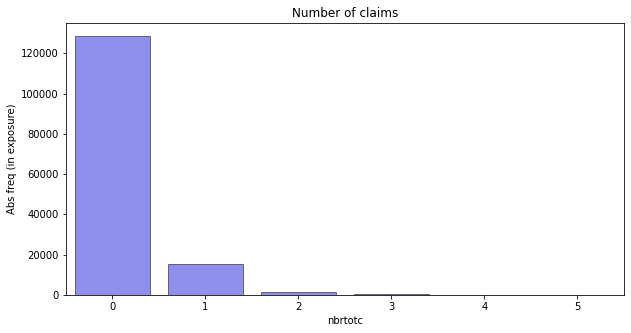

In [ ]:
plt.figure(figsize = (10, 5))
sns.barplot(data = emp_freq, x = "nbrtotc", y = "tot_expo", alpha = 0.5, color = "blue", edgecolor = 'black', linewidth = 1)
plt.ylabel("Abs freq (in exposure)")
plt.xlabel("nbrtotc")
plt.title('Number of claims')
plt.show()

**Explanatory Variables**

In [ ]:
print(my_data.AGEPH.value_counts().sort_index())


17      2
18     17
19    116
20    393
21    704
     ... 
91     12
92     16
93      9
94      3
95      5
Name: AGEPH, Length: 79, dtype: int64


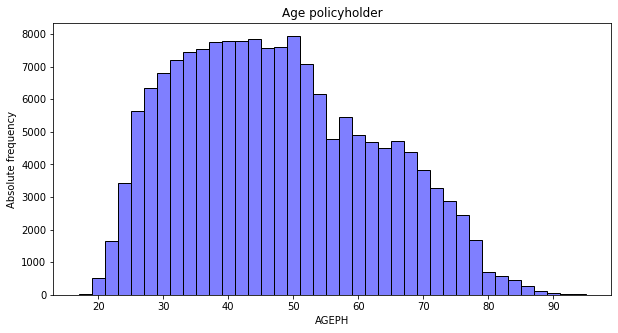

In [ ]:
plt.figure(figsize = (10, 5))
sns.histplot(data = my_data, x = "AGEPH", color = "blue", binwidth = 2, alpha = 0.5)
plt.ylabel("Absolute frequency")
plt.title('Age policyholder')
plt.show()

In [ ]:
my_data['AGEPH_cat'] = np.where(my_data['AGEPH'] < 20, "17-19", np.where(my_data['AGEPH'] < 23 ,"20-22", \
                              np.where(my_data['AGEPH'] < 26, "23-25", np.where(my_data['AGEPH'] < 31, "26-30", \
                              np.where(my_data['AGEPH'] < 36, "31-35", np.where(my_data['AGEPH'] < 41, "36-40", \
                              np.where(my_data['AGEPH'] < 46, "41-45", np.where(my_data['AGEPH'] < 51, "46-50", \
                              np.where(my_data['AGEPH'] < 56, "51-55", np.where(my_data['AGEPH'] < 61, "56-60", \
                              np.where(my_data['AGEPH'] < 66, "61-65", np.where(my_data['AGEPH'] < 71, "66-70", \
                              np.where(my_data['AGEPH'] < 76, "71-75", np.where(my_data['AGEPH'] < 81, "76-80", ">80"))))))))))))))

In [ ]:
my_data['AGEPH_cat'].value_counts().sort_index()

17-19      135
20-22     2050
23-25     6092
26-30    16074
31-35    18362
36-40    19337
41-45    19539
46-50    19183
51-55    15728
56-60    12621
61-65    11509
66-70    10606
71-75     7432
76-80     3505
>80       1484
Name: AGEPH_cat, dtype: int64

In [ ]:
print(my_data.CODPOSS.value_counts().sort_index())

1000    1181
1030     928
1040     433
1050     643
1060     345
        ... 
9950     110
9960     185
9970      48
9980      39
9990     136
Name: CODPOSS, Length: 583, dtype: int64


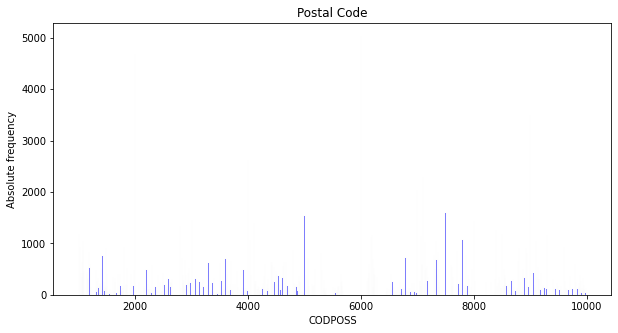

In [ ]:
plt.figure(figsize = (10, 5))
sns.histplot(data = my_data, x = "CODPOSS", color = "blue", binwidth = 2, alpha = 0.5)
plt.ylabel("Absolute frequency")
plt.title('Postal Code')
plt.show()

In [ ]:
print(my_data.agecar.value_counts().sort_index())

0-1      7766
2-5     51559
6-10    67151
>10     37181
Name: agecar, dtype: int64


In [ ]:
my_data.sexp.value_counts()

Male      120434
Female     43223
Name: sexp, dtype: int64

In [ ]:
my_data.fuelc.value_counts()

Petrol    113210
Gasoil     50447
Name: fuelc, dtype: int64

In [ ]:
my_data.split.value_counts()

Once       81479
Twice      45961
Monthly    23599
Thrice     12618
Name: split, dtype: int64

In [ ]:
my_data.usec.value_counts()

Private         155652
Professional      8005
Name: usec, dtype: int64

In [ ]:
my_data.fleetc.value_counts()

No     158428
Yes      5229
Name: fleetc, dtype: int64

In [ ]:
my_data.sportc.value_counts()

No     162145
Yes      1512
Name: sportc, dtype: int64

In [ ]:
my_data.coverp.value_counts()

MTPL       95409
MTPL+      46073
MTPL+++    22175
Name: coverp, dtype: int64

In [ ]:
my_data.powerc.value_counts()

<66       119809
66-110     42188
>110        1660
Name: powerc, dtype: int64

In [ ]:
for c in ["AGEPH","CODPOSS","agecar","sexp","fuelc","split","usec","fleetc","sportc","coverp","powerc","AGEPH_cat"]:
    my_data[c]=pd.Categorical(my_data[c])

my_data["split"] = my_data["split"].cat.reorder_categories(['Once','Twice','Thrice','Monthly'])
my_data["powerc"] = my_data["powerc"].cat.reorder_categories(['<66', '66-110','>110'])

my_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163657 entries, 0 to 163656
Data columns (total 17 columns):
 #   Column     Non-Null Count   Dtype   
---  ------     --------------   -----   
 0   AGEPH      163657 non-null  category
 1   CODPOSS    163657 non-null  category
 2   duree      163657 non-null  float64 
 3   lnexpo     163657 non-null  float64 
 4   nbrtotc    163657 non-null  int64   
 5   nbrtotan   163657 non-null  float64 
 6   chargtot   163657 non-null  float64 
 7   agecar     163657 non-null  category
 8   sexp       163657 non-null  category
 9   fuelc      163657 non-null  category
 10  split      163657 non-null  category
 11  usec       163657 non-null  category
 12  fleetc     163657 non-null  category
 13  sportc     163657 non-null  category
 14  coverp     163657 non-null  category
 15  powerc     163657 non-null  category
 16  AGEPH_cat  163657 non-null  category
dtypes: category(12), float64(4), int64(1)
memory usage: 8.3 MB


**One way analysis**

In [ ]:
def my_data_description(variable):
    
    Nbr = my_data[['nbrtotc']].groupby([my_data[variable]]).sum().reset_index()
    exp = my_data[['duree']].groupby([my_data[variable]]).sum().reset_index()
    obs = pd.merge(Nbr,exp)
    obs['Freq']=obs['nbrtotc']/obs['duree']
   
    return(obs)

In [ ]:
def my_data_description_plot(variable):

    plt.rcParams['figure.figsize'] = [15, 6]
    table_to_plot=table.loc[:,[variable,'duree','Freq']]
    table_to_plot.plot(kind='bar', secondary_y='duree', rot=0)
    plt.xticks(range(table_to_plot.shape[0]),list(table_to_plot.iloc[:,0]))
    plot=plt.show()
    
    return(plot)

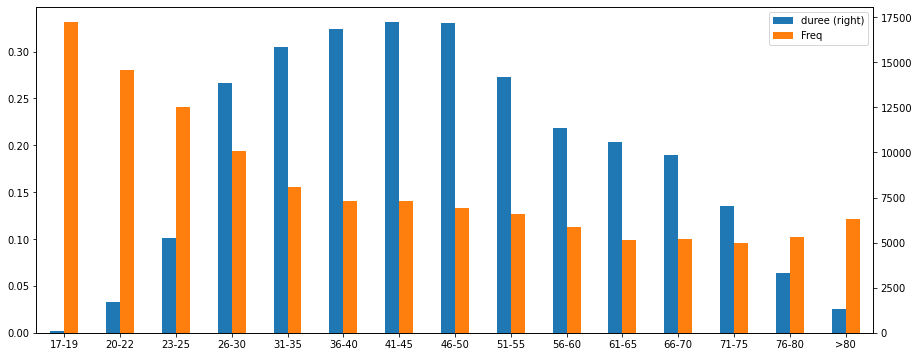

In [ ]:
table=my_data_description("AGEPH_cat")
my_data_description_plot("AGEPH_cat")

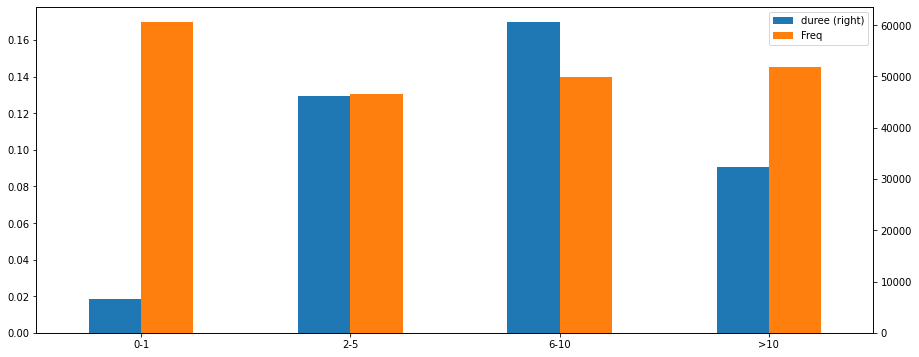

In [ ]:
table=my_data_description("agecar")
my_data_description_plot("agecar")

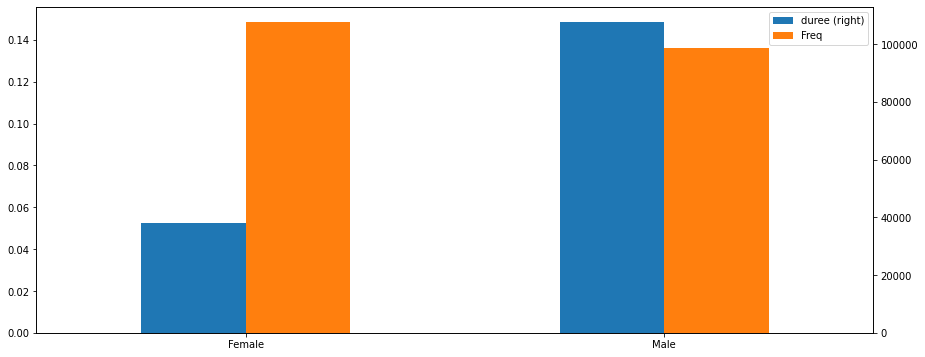

In [ ]:
table=my_data_description("sexp")
my_data_description_plot("sexp")

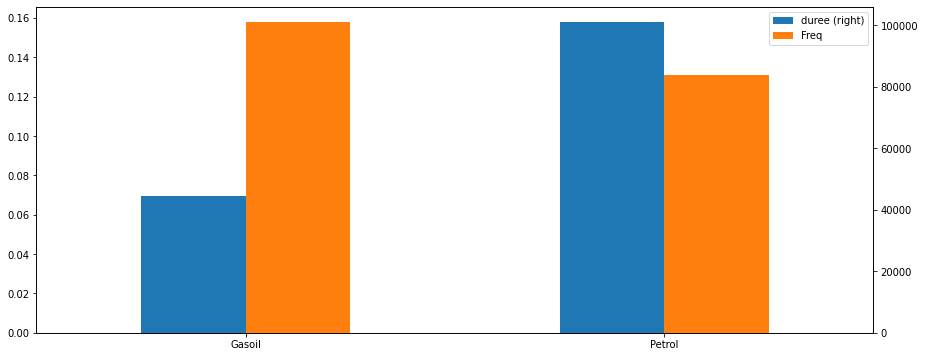

In [ ]:
table=my_data_description("fuelc")
my_data_description_plot("fuelc")

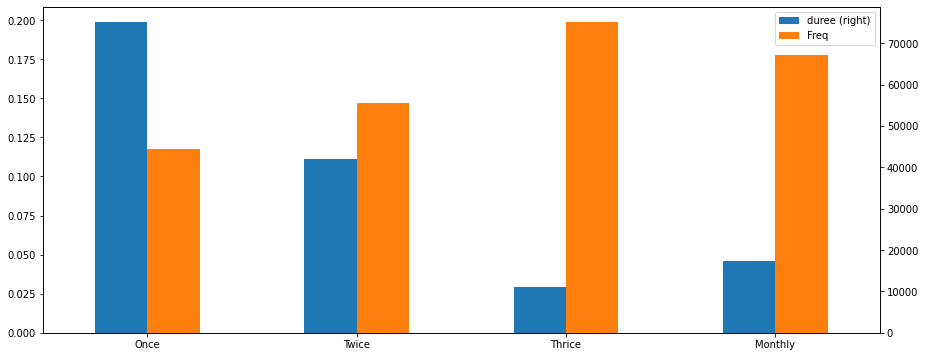

In [ ]:
table=my_data_description("split")
my_data_description_plot("split")

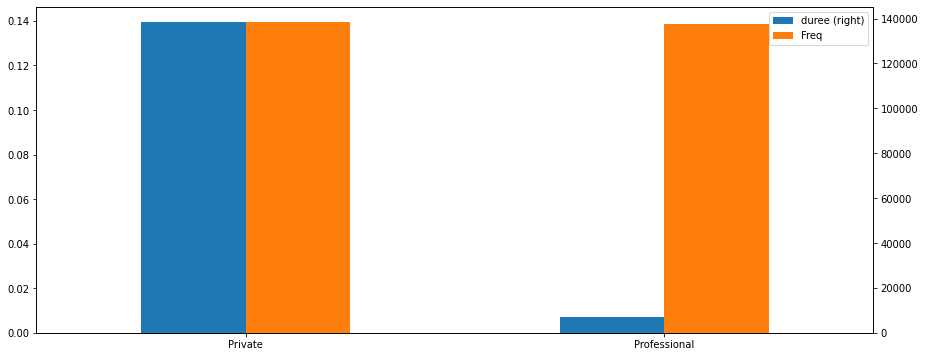

In [ ]:
table=my_data_description("usec")
my_data_description_plot("usec")

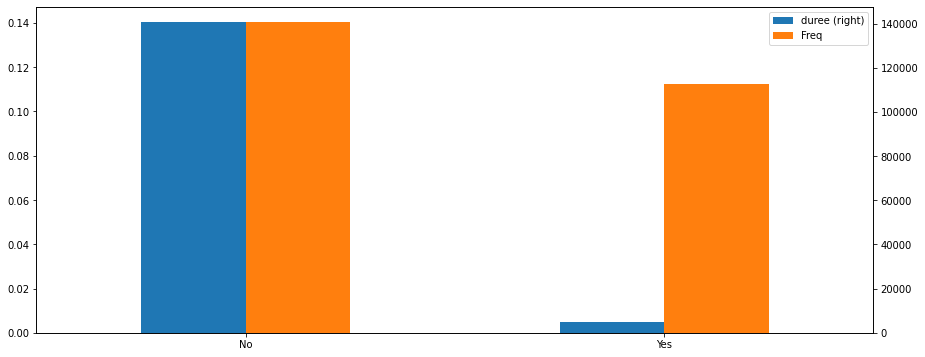

In [ ]:
table=my_data_description("fleetc")
my_data_description_plot("fleetc")

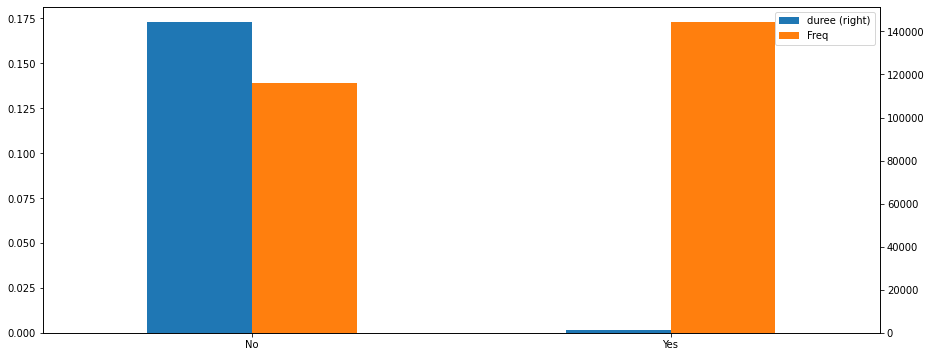

In [ ]:
table=my_data_description("sportc")
my_data_description_plot("sportc")

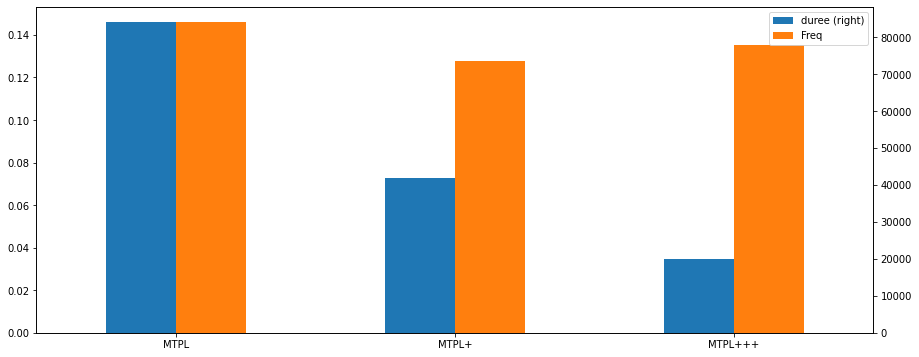

In [ ]:
table=my_data_description("coverp")
my_data_description_plot("coverp")

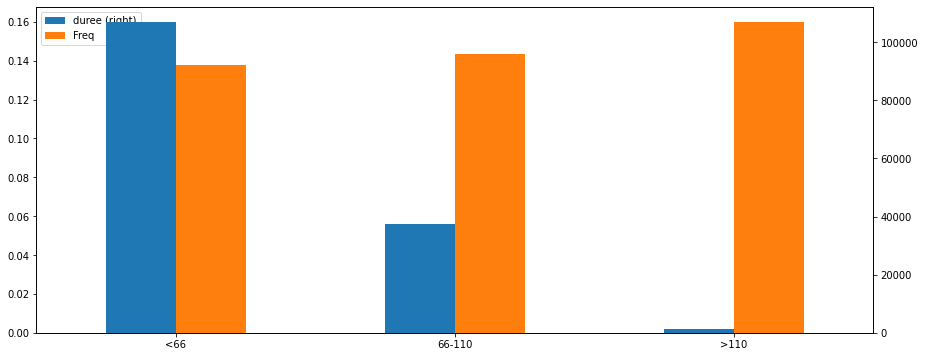

In [ ]:
table=my_data_description("powerc")
my_data_description_plot("powerc")

#### Method 1 : GLM

**Split train-test**

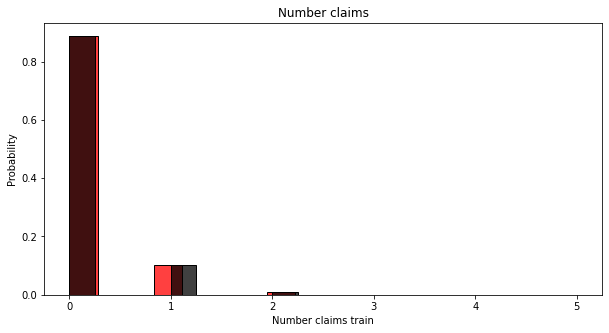

In [ ]:
np.random.seed(123)
bins = np.linspace(my_data.nbrtotc.min(),my_data.nbrtotc.max(), 20 ) 
y_cat = pd.cut(my_data.nbrtotc,bins=bins,include_lowest=True) 
my_data_X = my_data.drop(labels=['CODPOSS','lnexpo','nbrtotc','nbrtotan','chargtot'], axis=1) 
my_data_X_train, my_data_X_test, my_data_y_train, my_data_y_test = train_test_split(my_data_X, my_data.nbrtotc, test_size=0.2, stratify=y_cat)
train=my_data_X_train
train["nbrtotc"]=my_data_y_train

test=my_data_X_test
test["nbrtotc"]=my_data_y_test

#create dataframe from different vector lengths
df1 = pd.DataFrame(my_data_y_train)
df2= pd.DataFrame(my_data_y_test)
plot_pd = pd.concat([df1,df2], ignore_index=True, axis=1)
#rename columns for x-label
plot_pd.columns = ['Number claims train', 'Number claims test']
#plot 

fig, axs = plt.subplots(ncols=1, figsize=(10,5));
sns.histplot(plot_pd['Number claims train'], ax = axs, color='r',stat="probability").set(title='Number claims');
sns.histplot(plot_pd['Number claims test'], ax = axs, color='k',stat="probability");
plt.show()

**Our first model: a model with only an intercept**

In [ ]:
freq_glm = smf.glm('nbrtotc ~ 1', data = train, exposure = train.duree, family = sm.families.Poisson(link=sm.families.links.log())).fit()
print(freq_glm.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                nbrtotc   No. Observations:               130925
Model:                            GLM   Df Residuals:                   130924
Model Family:                 Poisson   Df Model:                            0
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -51203.
Date:                Thu, 13 Jan 2022   Deviance:                       72137.
Time:                        15:22:52   Pearson chi2:                 1.60e+05
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.9705      0.008   -251.080      0.0

In [ ]:
print(freq_glm.deviance)
print("")
print("")
print(freq_glm.aic)

72136.93569151955


102407.07565884573


**Models with one variable**

In [ ]:
freq_glm_AGEPH_cat = smf.glm('nbrtotc ~ C(AGEPH_cat,Treatment(reference="41-45"))', data = train, exposure = train.duree, family = sm.families.Poisson(link=sm.families.links.log())).fit()
freq_glm_agecar = smf.glm('nbrtotc ~ C(agecar,Treatment(reference="6-10"))', data = train, exposure = train.duree, family = sm.families.Poisson(link=sm.families.links.log())).fit()
freq_glm_sexp = smf.glm('nbrtotc ~ sexp', data = train, exposure = train.duree, family = sm.families.Poisson(link=sm.families.links.log())).fit()
freq_glm_fuelc = smf.glm('nbrtotc ~ fuelc', data = train, exposure = train.duree, family = sm.families.Poisson(link=sm.families.links.log())).fit()
freq_glm_split = smf.glm('nbrtotc ~ C(split,Treatment(reference="Once"))', data = train, exposure = train.duree, family = sm.families.Poisson(link=sm.families.links.log())).fit()
freq_glm_usec = smf.glm('nbrtotc ~ usec', data = train, exposure = train.duree, family = sm.families.Poisson(link=sm.families.links.log())).fit()
freq_glm_fleetc = smf.glm('nbrtotc ~ fleetc', data = train, exposure = train.duree, family = sm.families.Poisson(link=sm.families.links.log())).fit()
freq_glm_sportc = smf.glm('nbrtotc ~ sportc', data = train, exposure = train.duree, family = sm.families.Poisson(link=sm.families.links.log())).fit()
freq_glm_coverp = smf.glm('nbrtotc ~ C(coverp,Treatment(reference="MTPL"))', data = train, exposure = train.duree, family = sm.families.Poisson(link=sm.families.links.log())).fit()
freq_glm_powerc = smf.glm('nbrtotc ~ C(powerc,Treatment(reference="<66"))', data = train, exposure = train.duree, family = sm.families.Poisson(link=sm.families.links.log())).fit()

In [ ]:
print(freq_glm.deviance)
print("")
print(freq_glm_AGEPH_cat.deviance)
print(freq_glm_agecar.deviance)
print(freq_glm_sexp.deviance)
print(freq_glm_fuelc.deviance)
print(freq_glm_split.deviance)
print(freq_glm_usec.deviance)
print(freq_glm_fleetc.deviance)
print(freq_glm_sportc.deviance)
print(freq_glm_coverp.deviance)
print(freq_glm_powerc.deviance)
print("")
print("")
print(freq_glm.aic)
print("")
print(freq_glm_AGEPH_cat.aic)
print(freq_glm_agecar.aic)
print(freq_glm_sexp.aic)
print(freq_glm_fuelc.aic)
print(freq_glm_split.aic)
print(freq_glm_usec.aic)
print(freq_glm_fleetc.aic)
print(freq_glm_sportc.aic)
print(freq_glm_coverp.aic)
print(freq_glm_powerc.aic)

72136.93569151955

71069.3645862244
72075.72299658494
72117.47475146624
72020.2472805242
71555.2369138079
72136.19162125122
72111.26008292731
72129.35522503633
72091.13418442827
72128.78898135827


102407.07565884573

101367.50455355059
102351.86296391112
102389.61471879244
102292.38724785042
101831.37688113409
102408.33158857738
102383.40005025352
102401.49519236253
102365.27415175446
102402.92894868445


Looking at the metrics, we decide to keep AGEPH_cat as our first variable.

In [ ]:
freq_glm1 = smf.glm('nbrtotc ~ C(AGEPH_cat,Treatment(reference="41-45"))', data = train, exposure = train.duree, family = sm.families.Poisson(link=sm.families.links.log())).fit()
print(freq_glm1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                nbrtotc   No. Observations:               130925
Model:                            GLM   Df Residuals:                   130910
Model Family:                 Poisson   Df Model:                           14
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -50669.
Date:                Thu, 13 Jan 2022   Deviance:                       71069.
Time:                        15:22:58   Pearson chi2:                 1.56e+05
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                                                          coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------

We see high p-values for the classes 36-40 & 46-50. As these classes are adjacent to the reference class, we decide to gather these classes with the reference class.

In [ ]:
train['AGEPH_cat_2']=train['AGEPH_cat'].astype('object')
train.loc[train['AGEPH_cat'].isin(["36-40","41-45"]),'AGEPH_cat_2']="36-45"
train['AGEPH_cat_2']=train['AGEPH_cat_2'].astype('category')
print(train.AGEPH_cat.value_counts())
print("")
print(train.AGEPH_cat_2.value_counts())

test['AGEPH_cat_2']=test['AGEPH_cat'].astype('object')
test.loc[test['AGEPH_cat'].isin(["36-40","41-45"]),'AGEPH_cat_2']="36-45"
test['AGEPH_cat_2']=test['AGEPH_cat_2'].astype('category')
print(test.AGEPH_cat.value_counts())
print("")
print(test.AGEPH_cat_2.value_counts())

my_data['AGEPH_cat_2']=my_data['AGEPH_cat'].astype('object')
my_data.loc[my_data['AGEPH_cat'].isin(["36-40","41-45"]),'AGEPH_cat_2']="36-45"
my_data['AGEPH_cat_2']=my_data['AGEPH_cat_2'].astype('category')
print(my_data.AGEPH_cat.value_counts())
print("")
print(my_data.AGEPH_cat_2.value_counts())

41-45    15624
36-40    15468
46-50    15368
31-35    14691
26-30    12826
51-55    12543
56-60    10105
61-65     9303
66-70     8460
71-75     5916
23-25     4901
76-80     2792
20-22     1653
>80       1172
17-19      103
Name: AGEPH_cat, dtype: int64

36-45    31092
46-50    15368
31-35    14691
26-30    12826
51-55    12543
56-60    10105
61-65     9303
66-70     8460
71-75     5916
23-25     4901
76-80     2792
20-22     1653
>80       1172
17-19      103
Name: AGEPH_cat_2, dtype: int64
41-45    3915
36-40    3869
46-50    3815
31-35    3671
26-30    3248
51-55    3185
56-60    2516
61-65    2206
66-70    2146
71-75    1516
23-25    1191
76-80     713
20-22     397
>80       312
17-19      32
Name: AGEPH_cat, dtype: int64

36-45    7784
46-50    3815
31-35    3671
26-30    3248
51-55    3185
56-60    2516
61-65    2206
66-70    2146
71-75    1516
23-25    1191
76-80     713
20-22     397
>80       312
17-19      32
Name: AGEPH_cat_2, dtype: int64
41-45    19539
36-40    19337
46-

In [ ]:
freq_glm1 = smf.glm('nbrtotc ~ C(AGEPH_cat_2,Treatment(reference="36-45"))', data = train, exposure = train.duree, family = sm.families.Poisson(link=sm.families.links.log())).fit()
print(freq_glm1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                nbrtotc   No. Observations:               130925
Model:                            GLM   Df Residuals:                   130911
Model Family:                 Poisson   Df Model:                           13
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -50669.
Date:                Thu, 13 Jan 2022   Deviance:                       71069.
Time:                        15:22:59   Pearson chi2:                 1.56e+05
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                                                            coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------

In [ ]:
train['AGEPH_cat_3']=train['AGEPH_cat_2'].astype('object')
train.loc[train['AGEPH_cat_2'].isin(["36-45","46-50"]),'AGEPH_cat_3']="36-50"
train['AGEPH_cat_3']=train['AGEPH_cat_3'].astype('category')
print(train.AGEPH_cat_2.value_counts())
print("")
print(train.AGEPH_cat_3.value_counts())

test['AGEPH_cat_3']=test['AGEPH_cat_2'].astype('object')
test.loc[test['AGEPH_cat_2'].isin(["36-45","46-50"]),'AGEPH_cat_3']="36-50"
test['AGEPH_cat_3']=test['AGEPH_cat_3'].astype('category')
print(test.AGEPH_cat_2.value_counts())
print("")
print(test.AGEPH_cat_3.value_counts())

my_data['AGEPH_cat_3']=my_data['AGEPH_cat_2'].astype('object')
my_data.loc[my_data['AGEPH_cat_2'].isin(["36-45","46-50"]),'AGEPH_cat_3']="36-50"
my_data['AGEPH_cat_3']=my_data['AGEPH_cat_3'].astype('category')
print(my_data.AGEPH_cat_2.value_counts())
print("")
print(my_data.AGEPH_cat_3.value_counts())

36-45    31092
46-50    15368
31-35    14691
26-30    12826
51-55    12543
56-60    10105
61-65     9303
66-70     8460
71-75     5916
23-25     4901
76-80     2792
20-22     1653
>80       1172
17-19      103
Name: AGEPH_cat_2, dtype: int64

36-50    46460
31-35    14691
26-30    12826
51-55    12543
56-60    10105
61-65     9303
66-70     8460
71-75     5916
23-25     4901
76-80     2792
20-22     1653
>80       1172
17-19      103
Name: AGEPH_cat_3, dtype: int64
36-45    7784
46-50    3815
31-35    3671
26-30    3248
51-55    3185
56-60    2516
61-65    2206
66-70    2146
71-75    1516
23-25    1191
76-80     713
20-22     397
>80       312
17-19      32
Name: AGEPH_cat_2, dtype: int64

36-50    11599
31-35     3671
26-30     3248
51-55     3185
56-60     2516
61-65     2206
66-70     2146
71-75     1516
23-25     1191
76-80      713
20-22      397
>80        312
17-19       32
Name: AGEPH_cat_3, dtype: int64
36-45    38876
46-50    19183
31-35    18362
26-30    16074
51-55    15728

In [ ]:
freq_glm1 = smf.glm('nbrtotc ~ C(AGEPH_cat_3,Treatment(reference="36-50"))', data = train, exposure = train.duree, family = sm.families.Poisson(link=sm.families.links.log())).fit()
print(freq_glm1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                nbrtotc   No. Observations:               130925
Model:                            GLM   Df Residuals:                   130912
Model Family:                 Poisson   Df Model:                           12
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -50671.
Date:                Thu, 13 Jan 2022   Deviance:                       71073.
Time:                        15:23:00   Pearson chi2:                 1.56e+05
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                                                            coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------

Can we gather other adjacent categories for AGEPH_cat?

In [ ]:
def Wald_hypothesis(model,variable):

    params=pd.DataFrame(model.params)
    params_var=params.loc[np.array([s for s in params.index if variable in s])]
    cov=model.cov_params()
    cov_var=cov.loc[np.array([s for s in cov.index if variable in s]),np.array([s for s in cov.columns if variable in s])]
     
    wald_matrix = np.array([[0.000 for j in range(len(params_var))] for i in range(len(params_var))])

    for i in range(len(params_var)):
        for j in range(len(params_var)):
            wald_matrix[i,j]=(params_var.iloc[i]-params_var.iloc[j])**2/(cov_var.iloc[i,i] - 2*cov_var.iloc[i,j] + cov_var.iloc[j,j])

    return(wald_matrix.round(3))


In [ ]:
wald_table=Wald_hypothesis(freq_glm1,'AGEPH_cat_3')
wald_table=pd.DataFrame(wald_table, 
             columns=['17-19',
                      '20-22', 
                      '23-25', 
                      '26-30',
                      '31-35', 
                      '51-55',
                      '56-60',
                      '61-65',
                      '66-70',
                      '71-75',
                      '76-80',
                      '>80'])
wald_table['AGEPH_cat_3']=['17-19',
                      '20-22', 
                      '23-25', 
                      '26-30',
                      '31-35', 
                      '51-55',
                      '56-60',
                      '61-65',
                      '66-70',
                      '71-75',
                      '76-80',
                      '>80']
wald_table.set_index('AGEPH_cat_3')

,17-19,20-22,23-25,26-30,31-35,51-55,56-60,61-65,66-70,71-75,76-80,>80
AGEPH_cat_3,,,,,,,,,,,,
17-19,NaN,1.554,3.370,8.984,17.149,27.067,32.806,39.753,39.859,41.738,40.162,27.254
20-22,1.554,NaN,3.456,36.866,101.108,180.177,216.180,263.450,258.251,241.719,166.884,70.289
23-25,3.370,3.456,NaN,35.981,139.147,264.895,307.809,371.637,357.251,306.958,178.445,63.230
26-30,8.984,36.866,35.981,NaN,52.581,164.467,207.268,269.936,256.528,213.668,114.369,33.052
31-35,17.149,101.108,139.147,52.581,NaN,37.123,69.026,114.246,109.298,96.884,52.910,11.025
51-55,27.067,180.177,264.895,164.467,37.123,NaN,6.927,27.173,26.522,27.878,16.228,1.090
56-60,32.806,216.180,307.809,207.268,69.026,6.927,NaN,6.466,6.522,9.001,5.704,0.009
61-65,39.753,263.450,371.637,269.936,114.246,27.173,6.466,NaN,0.004,0.589,0.498,1.701
66-70,39.859,258.251,357.251,256.528,109.298,26.522,6.522,0.004,NaN,0.484,0.427,1.771


We check for values below 3.841 (the 95% quantile value). The smallest value is 0.004 for the classes 61-65 & 66-70.

In [ ]:
train['AGEPH_cat_4']=train['AGEPH_cat_3'].astype('object')
train.loc[train['AGEPH_cat_3'].isin(["61-65","66-70"]),'AGEPH_cat_4']="61-70"
train['AGEPH_cat_4']=train['AGEPH_cat_4'].astype('category')
print(train.AGEPH_cat_3.value_counts())
print("")
print(train.AGEPH_cat_4.value_counts())

test['AGEPH_cat_4']=test['AGEPH_cat_3'].astype('object')
test.loc[test['AGEPH_cat_3'].isin(["61-65","66-70"]),'AGEPH_cat_4']="61-70"
test['AGEPH_cat_4']=test['AGEPH_cat_4'].astype('category')
print(test.AGEPH_cat_3.value_counts())
print("")
print(test.AGEPH_cat_4.value_counts())

my_data['AGEPH_cat_4']=my_data['AGEPH_cat_3'].astype('object')
my_data.loc[my_data['AGEPH_cat_3'].isin(["61-65","66-70"]),'AGEPH_cat_4']="61-70"
my_data['AGEPH_cat_4']=my_data['AGEPH_cat_4'].astype('category')
print(my_data.AGEPH_cat_3.value_counts())
print("")
print(my_data.AGEPH_cat_4.value_counts())

36-50    46460
31-35    14691
26-30    12826
51-55    12543
56-60    10105
61-65     9303
66-70     8460
71-75     5916
23-25     4901
76-80     2792
20-22     1653
>80       1172
17-19      103
Name: AGEPH_cat_3, dtype: int64

36-50    46460
61-70    17763
31-35    14691
26-30    12826
51-55    12543
56-60    10105
71-75     5916
23-25     4901
76-80     2792
20-22     1653
>80       1172
17-19      103
Name: AGEPH_cat_4, dtype: int64
36-50    11599
31-35     3671
26-30     3248
51-55     3185
56-60     2516
61-65     2206
66-70     2146
71-75     1516
23-25     1191
76-80      713
20-22      397
>80        312
17-19       32
Name: AGEPH_cat_3, dtype: int64

36-50    11599
61-70     4352
31-35     3671
26-30     3248
51-55     3185
56-60     2516
71-75     1516
23-25     1191
76-80      713
20-22      397
>80        312
17-19       32
Name: AGEPH_cat_4, dtype: int64
36-50    58059
31-35    18362
26-30    16074
51-55    15728
56-60    12621
61-65    11509
66-70    10606
71-75     7432


In [ ]:
freq_glm1 = smf.glm('nbrtotc ~ C(AGEPH_cat_4,Treatment(reference="36-50"))', data = train, exposure = train.duree, family = sm.families.Poisson(link=sm.families.links.log())).fit()
print(freq_glm1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                nbrtotc   No. Observations:               130925
Model:                            GLM   Df Residuals:                   130913
Model Family:                 Poisson   Df Model:                           11
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -50671.
Date:                Thu, 13 Jan 2022   Deviance:                       71073.
Time:                        15:23:02   Pearson chi2:                 1.56e+05
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                                                            coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------

In [ ]:
wald_table=Wald_hypothesis(freq_glm1,'AGEPH_cat_4')
wald_table=pd.DataFrame(wald_table, 
             columns=['17-19',
                      '20-22', 
                      '23-25', 
                      '26-30',
                      '31-35', 
                      '51-55',
                      '56-60',
                      '61-70',
                      '71-75',
                      '76-80',
                      '>80'])
wald_table['AGEPH_cat_4']=['17-19',
                      '20-22', 
                      '23-25', 
                      '26-30',
                      '31-35', 
                      '51-55',
                      '56-60',
                      '61-70',
                      '71-75',
                      '76-80',
                      '>80']
wald_table.set_index('AGEPH_cat_4')

,17-19,20-22,23-25,26-30,31-35,51-55,56-60,61-70,71-75,76-80,>80
AGEPH_cat_4,,,,,,,,,,,
17-19,NaN,1.554,3.370,8.984,17.149,27.067,32.806,40.424,41.738,40.162,27.254
20-22,1.554,NaN,3.456,36.866,101.108,180.177,216.180,309.727,241.719,166.884,70.289
23-25,3.370,3.456,NaN,35.981,139.147,264.895,307.809,505.480,306.958,178.445,63.230
26-30,8.984,36.866,35.981,NaN,52.581,164.467,207.268,412.712,213.668,114.369,33.052
31-35,17.149,101.108,139.147,52.581,NaN,37.123,69.026,172.720,96.884,52.910,11.025
51-55,27.067,180.177,264.895,164.467,37.123,NaN,6.927,39.305,27.878,16.228,1.090
56-60,32.806,216.180,307.809,207.268,69.026,6.927,NaN,8.988,9.001,5.704,0.009
61-70,40.424,309.727,505.480,412.712,172.720,39.305,8.988,NaN,0.669,0.524,1.854
71-75,41.738,241.719,306.958,213.668,96.884,27.878,9.001,0.669,NaN,0.012,2.817


The smallest value is 0.012 for the classes 71-75 & 76-80.

In [ ]:
train['AGEPH_cat_5']=train['AGEPH_cat_4'].astype('object')
train.loc[train['AGEPH_cat_4'].isin(["71-75","76-80"]),'AGEPH_cat_5']="71-80"
train['AGEPH_cat_5']=train['AGEPH_cat_5'].astype('category')
print(train.AGEPH_cat_4.value_counts())
print("")
print(train.AGEPH_cat_5.value_counts())

test['AGEPH_cat_5']=test['AGEPH_cat_4'].astype('object')
test.loc[test['AGEPH_cat_4'].isin(["71-75","76-80"]),'AGEPH_cat_5']="71-80"
test['AGEPH_cat_5']=test['AGEPH_cat_5'].astype('category')
print(test.AGEPH_cat_4.value_counts())
print("")
print(test.AGEPH_cat_5.value_counts())

my_data['AGEPH_cat_5']=my_data['AGEPH_cat_4'].astype('object')
my_data.loc[my_data['AGEPH_cat_4'].isin(["71-75","76-80"]),'AGEPH_cat_5']="71-80"
my_data['AGEPH_cat_5']=my_data['AGEPH_cat_5'].astype('category')
print(my_data.AGEPH_cat_4.value_counts())
print("")
print(my_data.AGEPH_cat_5.value_counts())

36-50    46460
61-70    17763
31-35    14691
26-30    12826
51-55    12543
56-60    10105
71-75     5916
23-25     4901
76-80     2792
20-22     1653
>80       1172
17-19      103
Name: AGEPH_cat_4, dtype: int64

36-50    46460
61-70    17763
31-35    14691
26-30    12826
51-55    12543
56-60    10105
71-80     8708
23-25     4901
20-22     1653
>80       1172
17-19      103
Name: AGEPH_cat_5, dtype: int64
36-50    11599
61-70     4352
31-35     3671
26-30     3248
51-55     3185
56-60     2516
71-75     1516
23-25     1191
76-80      713
20-22      397
>80        312
17-19       32
Name: AGEPH_cat_4, dtype: int64

36-50    11599
61-70     4352
31-35     3671
26-30     3248
51-55     3185
56-60     2516
71-80     2229
23-25     1191
20-22      397
>80        312
17-19       32
Name: AGEPH_cat_5, dtype: int64
36-50    58059
61-70    22115
31-35    18362
26-30    16074
51-55    15728
56-60    12621
71-75     7432
23-25     6092
76-80     3505
20-22     2050
>80       1484
17-19      135


In [ ]:
freq_glm1 = smf.glm('nbrtotc ~ C(AGEPH_cat_5,Treatment(reference="36-50"))', data = train, exposure = train.duree, family = sm.families.Poisson(link=sm.families.links.log())).fit()
print(freq_glm1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                nbrtotc   No. Observations:               130925
Model:                            GLM   Df Residuals:                   130914
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -50671.
Date:                Thu, 13 Jan 2022   Deviance:                       71073.
Time:                        15:23:03   Pearson chi2:                 1.56e+05
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                                                            coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------

In [ ]:
wald_table=Wald_hypothesis(freq_glm1,'AGEPH_cat_5')
wald_table=pd.DataFrame(wald_table, 
             columns=['17-19',
                      '20-22', 
                      '23-25', 
                      '26-30',
                      '31-35', 
                      '51-55',
                      '56-60',
                      '61-70',
                      '71-80',
                      '>80'])
wald_table['AGEPH_cat_5']=['17-19',
                      '20-22', 
                      '23-25', 
                      '26-30',
                      '31-35', 
                      '51-55',
                      '56-60',
                      '61-70',
                      '71-80',
                      '>80']
wald_table.set_index('AGEPH_cat_5')

,17-19,20-22,23-25,26-30,31-35,51-55,56-60,61-70,71-80,>80
AGEPH_cat_5,,,,,,,,,,
17-19,NaN,1.554,3.370,8.984,17.149,27.067,32.806,40.424,42.540,27.254
20-22,1.554,NaN,3.456,36.866,101.108,180.177,216.180,309.727,279.874,70.289
23-25,3.370,3.456,NaN,35.981,139.147,264.895,307.809,505.480,390.783,63.230
26-30,8.984,36.866,35.981,NaN,52.581,164.467,207.268,412.712,289.054,33.052
31-35,17.149,101.108,139.147,52.581,NaN,37.123,69.026,172.720,130.703,11.025
51-55,27.067,180.177,264.895,164.467,37.123,NaN,6.927,39.305,37.005,1.090
56-60,32.806,216.180,307.809,207.268,69.026,6.927,NaN,8.988,11.772,0.009
61-70,40.424,309.727,505.480,412.712,172.720,39.305,8.988,NaN,1.001,1.854
71-80,42.540,279.874,390.783,289.054,130.703,37.005,11.772,1.001,NaN,3.089


The smallest value is 1.001 for the classes 61-70 & 71-80. 

In [ ]:
train['AGEPH_cat_6']=train['AGEPH_cat_5'].astype('object')
train.loc[train['AGEPH_cat_5'].isin(["61-70","71-80"]),'AGEPH_cat_6']="61-80"
train['AGEPH_cat_6']=train['AGEPH_cat_6'].astype('category')
print(train.AGEPH_cat_5.value_counts())
print("")
print(train.AGEPH_cat_6.value_counts())

test['AGEPH_cat_6']=test['AGEPH_cat_5'].astype('object')
test.loc[test['AGEPH_cat_5'].isin(["61-70","71-80"]),'AGEPH_cat_6']="61-80"
test['AGEPH_cat_6']=test['AGEPH_cat_6'].astype('category')
print(test.AGEPH_cat_5.value_counts())
print("")
print(test.AGEPH_cat_6.value_counts())

my_data['AGEPH_cat_6']=my_data['AGEPH_cat_5'].astype('object')
my_data.loc[my_data['AGEPH_cat_5'].isin(["61-70","71-80"]),'AGEPH_cat_6']="61-80"
my_data['AGEPH_cat_6']=my_data['AGEPH_cat_6'].astype('category')
print(my_data.AGEPH_cat_5.value_counts())
print("")
print(my_data.AGEPH_cat_6.value_counts())

36-50    46460
61-70    17763
31-35    14691
26-30    12826
51-55    12543
56-60    10105
71-80     8708
23-25     4901
20-22     1653
>80       1172
17-19      103
Name: AGEPH_cat_5, dtype: int64

36-50    46460
61-80    26471
31-35    14691
26-30    12826
51-55    12543
56-60    10105
23-25     4901
20-22     1653
>80       1172
17-19      103
Name: AGEPH_cat_6, dtype: int64
36-50    11599
61-70     4352
31-35     3671
26-30     3248
51-55     3185
56-60     2516
71-80     2229
23-25     1191
20-22      397
>80        312
17-19       32
Name: AGEPH_cat_5, dtype: int64

36-50    11599
61-80     6581
31-35     3671
26-30     3248
51-55     3185
56-60     2516
23-25     1191
20-22      397
>80        312
17-19       32
Name: AGEPH_cat_6, dtype: int64
36-50    58059
61-70    22115
31-35    18362
26-30    16074
51-55    15728
56-60    12621
71-80    10937
23-25     6092
20-22     2050
>80       1484
17-19      135
Name: AGEPH_cat_5, dtype: int64

36-50    58059
61-80    33052
31-35    183

In [ ]:
freq_glm1 = smf.glm('nbrtotc ~ C(AGEPH_cat_6,Treatment(reference="36-50"))', data = train, exposure = train.duree, family = sm.families.Poisson(link=sm.families.links.log())).fit()
print(freq_glm1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                nbrtotc   No. Observations:               130925
Model:                            GLM   Df Residuals:                   130915
Model Family:                 Poisson   Df Model:                            9
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -50671.
Date:                Thu, 13 Jan 2022   Deviance:                       71074.
Time:                        15:23:04   Pearson chi2:                 1.56e+05
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                                                            coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------

In [ ]:
wald_table=Wald_hypothesis(freq_glm1,'AGEPH_cat_6')
wald_table=pd.DataFrame(wald_table, 
             columns=['17-19',
                      '20-22', 
                      '23-25', 
                      '26-30',
                      '31-35', 
                      '51-55',
                      '56-60',
                      '61-80',
                      '>80'])
wald_table['AGEPH_cat_6']=['17-19',
                      '20-22', 
                      '23-25', 
                      '26-30',
                      '31-35', 
                      '51-55',
                      '56-60',
                      '61-80',
                      '>80']
wald_table.set_index('AGEPH_cat_6')

,17-19,20-22,23-25,26-30,31-35,51-55,56-60,61-80,>80
AGEPH_cat_6,,,,,,,,,
17-19,NaN,1.554,3.370,8.984,17.149,27.067,32.806,41.554,27.254
20-22,1.554,NaN,3.456,36.866,101.108,180.177,216.180,339.081,70.289
23-25,3.370,3.456,NaN,35.981,139.147,264.895,307.809,596.249,63.230
26-30,8.984,36.866,35.981,NaN,52.581,164.467,207.268,527.300,33.052
31-35,17.149,101.108,139.147,52.581,NaN,37.123,69.026,223.468,11.025
51-55,27.067,180.177,264.895,164.467,37.123,NaN,6.927,52.218,1.090
56-60,32.806,216.180,307.809,207.268,69.026,6.927,NaN,12.860,0.009
61-80,41.554,339.081,596.249,527.300,223.468,52.218,12.860,NaN,2.340
>80,27.254,70.289,63.230,33.052,11.025,1.090,0.009,2.340,NaN


The smallest value is 1.554 for the classes 17-19 & 20-22.

In [ ]:
train['AGEPH_cat_7']=train['AGEPH_cat_6'].astype('object')
train.loc[train['AGEPH_cat_6'].isin(["17-19","20-22"]),'AGEPH_cat_7']="17-22"
train['AGEPH_cat_7']=train['AGEPH_cat_7'].astype('category')
print(train.AGEPH_cat_6.value_counts())
print("")
print(train.AGEPH_cat_7.value_counts())

test['AGEPH_cat_7']=test['AGEPH_cat_6'].astype('object')
test.loc[test['AGEPH_cat_6'].isin(["17-19","20-22"]),'AGEPH_cat_7']="17-22"
test['AGEPH_cat_7']=test['AGEPH_cat_7'].astype('category')
print(test.AGEPH_cat_6.value_counts())
print("")
print(test.AGEPH_cat_7.value_counts())

my_data['AGEPH_cat_7']=my_data['AGEPH_cat_6'].astype('object')
my_data.loc[my_data['AGEPH_cat_6'].isin(["17-19","20-22"]),'AGEPH_cat_7']="17-22"
my_data['AGEPH_cat_7']=my_data['AGEPH_cat_7'].astype('category')
print(my_data.AGEPH_cat_6.value_counts())
print("")
print(my_data.AGEPH_cat_7.value_counts())

36-50    46460
61-80    26471
31-35    14691
26-30    12826
51-55    12543
56-60    10105
23-25     4901
20-22     1653
>80       1172
17-19      103
Name: AGEPH_cat_6, dtype: int64

36-50    46460
61-80    26471
31-35    14691
26-30    12826
51-55    12543
56-60    10105
23-25     4901
17-22     1756
>80       1172
Name: AGEPH_cat_7, dtype: int64
36-50    11599
61-80     6581
31-35     3671
26-30     3248
51-55     3185
56-60     2516
23-25     1191
20-22      397
>80        312
17-19       32
Name: AGEPH_cat_6, dtype: int64

36-50    11599
61-80     6581
31-35     3671
26-30     3248
51-55     3185
56-60     2516
23-25     1191
17-22      429
>80        312
Name: AGEPH_cat_7, dtype: int64
36-50    58059
61-80    33052
31-35    18362
26-30    16074
51-55    15728
56-60    12621
23-25     6092
20-22     2050
>80       1484
17-19      135
Name: AGEPH_cat_6, dtype: int64

36-50    58059
61-80    33052
31-35    18362
26-30    16074
51-55    15728
56-60    12621
23-25     6092
17-22     21

In [ ]:
freq_glm1 = smf.glm('nbrtotc ~ C(AGEPH_cat_7,Treatment(reference="36-50"))', data = train, exposure = train.duree, family = sm.families.Poisson(link=sm.families.links.log())).fit()
print(freq_glm1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                nbrtotc   No. Observations:               130925
Model:                            GLM   Df Residuals:                   130916
Model Family:                 Poisson   Df Model:                            8
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -50672.
Date:                Thu, 13 Jan 2022   Deviance:                       71075.
Time:                        15:23:05   Pearson chi2:                 1.56e+05
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                                                            coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------

In [ ]:
wald_table=Wald_hypothesis(freq_glm1,'AGEPH_cat_7')
wald_table=pd.DataFrame(wald_table, 
             columns=['17-22',
                      '23-25', 
                      '26-30',
                      '31-35', 
                      '51-55',
                      '56-60',
                      '61-80',
                      '>80'])
wald_table['AGEPH_cat_7']=['17-22',
                      '23-25', 
                      '26-30',
                      '31-35', 
                      '51-55',
                      '56-60',
                      '61-80',
                      '>80']
wald_table.set_index('AGEPH_cat_7')

,17-22,23-25,26-30,31-35,51-55,56-60,61-80,>80
AGEPH_cat_7,,,,,,,,
17-22,NaN,4.628,42.408,112.429,196.969,234.335,369.362,73.784
23-25,4.628,NaN,35.981,139.147,264.895,307.809,596.249,63.230
26-30,42.408,35.981,NaN,52.581,164.467,207.268,527.300,33.052
31-35,112.429,139.147,52.581,NaN,37.123,69.026,223.468,11.025
51-55,196.969,264.895,164.467,37.123,NaN,6.927,52.218,1.090
56-60,234.335,307.809,207.268,69.026,6.927,NaN,12.860,0.009
61-80,369.362,596.249,527.300,223.468,52.218,12.860,NaN,2.340
>80,73.784,63.230,33.052,11.025,1.090,0.009,2.340,NaN


The smallest value is 2.340 for the classes 61-80 & >80.

In [ ]:
train['AGEPH_cat_8']=train['AGEPH_cat_7'].astype('object')
train.loc[train['AGEPH_cat_7'].isin(["61-80",">80"]),'AGEPH_cat_8']=">60"
train['AGEPH_cat_8']=train['AGEPH_cat_8'].astype('category')
print(train.AGEPH_cat_7.value_counts())
print("")
print(train.AGEPH_cat_8.value_counts())

test['AGEPH_cat_8']=test['AGEPH_cat_7'].astype('object')
test.loc[test['AGEPH_cat_7'].isin(["61-80",">80"]),'AGEPH_cat_8']=">60"
test['AGEPH_cat_8']=test['AGEPH_cat_8'].astype('category')
print(test.AGEPH_cat_7.value_counts())
print("")
print(test.AGEPH_cat_8.value_counts())

my_data['AGEPH_cat_8']=my_data['AGEPH_cat_7'].astype('object')
my_data.loc[my_data['AGEPH_cat_7'].isin(["61-80",">80"]),'AGEPH_cat_8']=">60"
my_data['AGEPH_cat_8']=my_data['AGEPH_cat_8'].astype('category')
print(my_data.AGEPH_cat_7.value_counts())
print("")
print(my_data.AGEPH_cat_8.value_counts())

36-50    46460
61-80    26471
31-35    14691
26-30    12826
51-55    12543
56-60    10105
23-25     4901
17-22     1756
>80       1172
Name: AGEPH_cat_7, dtype: int64

36-50    46460
>60      27643
31-35    14691
26-30    12826
51-55    12543
56-60    10105
23-25     4901
17-22     1756
Name: AGEPH_cat_8, dtype: int64
36-50    11599
61-80     6581
31-35     3671
26-30     3248
51-55     3185
56-60     2516
23-25     1191
17-22      429
>80        312
Name: AGEPH_cat_7, dtype: int64

36-50    11599
>60       6893
31-35     3671
26-30     3248
51-55     3185
56-60     2516
23-25     1191
17-22      429
Name: AGEPH_cat_8, dtype: int64
36-50    58059
61-80    33052
31-35    18362
26-30    16074
51-55    15728
56-60    12621
23-25     6092
17-22     2185
>80       1484
Name: AGEPH_cat_7, dtype: int64

36-50    58059
>60      34536
31-35    18362
26-30    16074
51-55    15728
56-60    12621
23-25     6092
17-22     2185
Name: AGEPH_cat_8, dtype: int64


In [ ]:
freq_glm1 = smf.glm('nbrtotc ~ C(AGEPH_cat_8,Treatment(reference="36-50"))', data = train, exposure = train.duree, family = sm.families.Poisson(link=sm.families.links.log())).fit()
print(freq_glm1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                nbrtotc   No. Observations:               130925
Model:                            GLM   Df Residuals:                   130917
Model Family:                 Poisson   Df Model:                            7
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -50673.
Date:                Thu, 13 Jan 2022   Deviance:                       71078.
Time:                        15:23:06   Pearson chi2:                 1.56e+05
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                                                            coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------

In [ ]:
wald_table=Wald_hypothesis(freq_glm1,'AGEPH_cat_8')
wald_table=pd.DataFrame(wald_table, 
             columns=['17-22',
                      '23-25', 
                      '26-30',
                      '31-35', 
                      '51-55',
                      '56-60',
                      '>60'])
wald_table['AGEPH_cat_8']=['17-22',
                      '23-25', 
                      '26-30',
                      '31-35', 
                      '51-55',
                      '56-60',
                      '>60']
wald_table.set_index('AGEPH_cat_8')

,17-22,23-25,26-30,31-35,51-55,56-60,>60
AGEPH_cat_8,,,,,,,
17-22,NaN,4.628,42.408,112.429,196.969,234.335,367.340
23-25,4.628,NaN,35.981,139.147,264.895,307.809,596.420
26-30,42.408,35.981,NaN,52.581,164.467,207.268,529.348
31-35,112.429,139.147,52.581,NaN,37.123,69.026,221.995
51-55,196.969,264.895,164.467,37.123,NaN,6.927,50.400
56-60,234.335,307.809,207.268,69.026,6.927,NaN,11.838
>60,367.340,596.420,529.348,221.995,50.400,11.838,NaN


No more gathering of adjacent classes can be performed.

**Adding a second variable**

First we check for correlations using Cramers V test.

In [ ]:
# no package in python allows to compute Cramer V like in R
# we can use the solution here : https://stackoverflow.com/questions/46498455/categorical-features-correlation/46498792#46498792
# Check needed : https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V
def cramers_v(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher,
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))


confusion_matrix=pd.crosstab(my_data["AGEPH_cat_8"], my_data["agecar"])
print(cramers_v(confusion_matrix.values)) 

confusion_matrix=pd.crosstab(my_data["AGEPH_cat_8"], my_data["sexp"])
print(cramers_v(confusion_matrix.values))

confusion_matrix=pd.crosstab(my_data["AGEPH_cat_8"], my_data["fuelc"])
print(cramers_v(confusion_matrix.values))

confusion_matrix=pd.crosstab(my_data["AGEPH_cat_8"], my_data["split"])
print(cramers_v(confusion_matrix.values))

confusion_matrix=pd.crosstab(my_data["AGEPH_cat_8"], my_data["usec"])
print(cramers_v(confusion_matrix.values))

confusion_matrix=pd.crosstab(my_data["AGEPH_cat_8"], my_data["fleetc"])
print(cramers_v(confusion_matrix.values))

confusion_matrix=pd.crosstab(my_data["AGEPH_cat_8"], my_data["sportc"])
print(cramers_v(confusion_matrix.values))

confusion_matrix=pd.crosstab(my_data["AGEPH_cat_8"], my_data["coverp"])
print(cramers_v(confusion_matrix.values))

confusion_matrix=pd.crosstab(my_data["AGEPH_cat_8"], my_data["powerc"])
print(cramers_v(confusion_matrix.values))

0.03322420148823013
0.141899224481922
0.14844173423388404
0.13970415754794754
0.057757840061371024
0.06469910903787408
0.05322718260605714
0.06466420188888544
0.051546254773571776


In [ ]:
freq_glm2_agecar = smf.glm('nbrtotc ~ C(AGEPH_cat_8,Treatment(reference="36-50")) + C(agecar,Treatment(reference="6-10"))', data = train, exposure = train.duree, family = sm.families.Poisson(link=sm.families.links.log())).fit()
freq_glm2_sexp = smf.glm('nbrtotc ~ C(AGEPH_cat_8,Treatment(reference="36-50")) + sexp', data = train, exposure = train.duree, family = sm.families.Poisson(link=sm.families.links.log())).fit()
freq_glm2_fuelc = smf.glm('nbrtotc ~ C(AGEPH_cat_8,Treatment(reference="36-50")) + fuelc', data = train, exposure = train.duree, family = sm.families.Poisson(link=sm.families.links.log())).fit()
freq_glm2_split = smf.glm('nbrtotc ~ C(AGEPH_cat_8,Treatment(reference="36-50")) + C(split,Treatment(reference="Once"))', data = train, exposure = train.duree, family = sm.families.Poisson(link=sm.families.links.log())).fit()
freq_glm2_usec = smf.glm('nbrtotc ~ C(AGEPH_cat_8,Treatment(reference="36-50")) + usec', data = train, exposure = train.duree, family = sm.families.Poisson(link=sm.families.links.log())).fit()
freq_glm2_fleetc = smf.glm('nbrtotc ~ C(AGEPH_cat_8,Treatment(reference="36-50")) + fleetc', data = train, exposure = train.duree, family = sm.families.Poisson(link=sm.families.links.log())).fit()
freq_glm2_sportc = smf.glm('nbrtotc ~ C(AGEPH_cat_8,Treatment(reference="36-50")) + sportc', data = train, exposure = train.duree, family = sm.families.Poisson(link=sm.families.links.log())).fit()
freq_glm2_coverp = smf.glm('nbrtotc ~ C(AGEPH_cat_8,Treatment(reference="36-50")) + C(coverp,Treatment(reference="MTPL"))', data = train, exposure = train.duree, family = sm.families.Poisson(link=sm.families.links.log())).fit()
freq_glm2_powerc = smf.glm('nbrtotc ~ C(AGEPH_cat_8,Treatment(reference="36-50")) + C(powerc,Treatment(reference="<66"))', data = train, exposure = train.duree, family = sm.families.Poisson(link=sm.families.links.log())).fit()

In [ ]:
print(freq_glm1.deviance)
print("")
print(freq_glm2_agecar.deviance)
print(freq_glm2_sexp.deviance)
print(freq_glm2_fuelc.deviance)
print(freq_glm2_split.deviance)
print(freq_glm2_usec.deviance)
print(freq_glm2_fleetc.deviance)
print(freq_glm2_sportc.deviance)
print(freq_glm2_coverp.deviance)
print(freq_glm2_powerc.deviance)
print("")
print("")
print(freq_glm1.aic)
print("")
print(freq_glm2_agecar.aic)
print(freq_glm2_sexp.aic)
print(freq_glm2_fuelc.aic)
print(freq_glm2_split.aic)
print(freq_glm2_usec.aic)
print(freq_glm2_fleetc.aic)
print(freq_glm2_sportc.aic)
print(freq_glm2_coverp.aic)
print(freq_glm2_powerc.aic)

71077.59290485336

71017.58237227166
71077.57846809474
71012.81523904632
70709.49903408285
71077.42771058442
71067.92995461782
71076.62718240649
71056.60294429224
71063.5675632619


101361.73287217955

101307.72233959785
101363.71843542095
101298.95520637253
100999.63900140903
101363.56767791061
101354.069921944
101362.76714973268
101344.74291161842
101351.70753058807


Looking at the metrics, we decide to keep split as our second variable.

In [ ]:
freq_glm2 = smf.glm('nbrtotc ~ C(AGEPH_cat_8,Treatment(reference="36-50")) + C(split,Treatment(reference="Once"))', data = train, exposure = train.duree, family = sm.families.Poisson(link=sm.families.links.log())).fit()
print(freq_glm2.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                nbrtotc   No. Observations:               130925
Model:                            GLM   Df Residuals:                   130914
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -50489.
Date:                Thu, 13 Jan 2022   Deviance:                       70709.
Time:                        15:23:15   Pearson chi2:                 1.54e+05
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                                                            coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------

There are no high p-values. Can we gather adjacent classes?

In [ ]:
wald_table=Wald_hypothesis(freq_glm2,'split')
wald_table=pd.DataFrame(wald_table, 
             columns=['Twice',
                      'Thrice', 
                      'Monthly'])
wald_table['split']=['Twice',
                      'Thrice', 
                      'Monthly']
wald_table.set_index('split')

,Twice,Thrice,Monthly
split,,,
Twice,NaN,64.652,65.388
Thrice,64.652,NaN,0.544
Monthly,65.388,0.544,NaN



The smallest value is 0.544 for the classes Thrice & Monthly.

In [ ]:
train['split_2']=train['split'].astype('object')
train.loc[train['split'].isin(["Thrice","Monthly"]),'split_2']="Thrice&Monthly"
train['split_2']=train['split_2'].astype('category')
print(train.split.value_counts())
print("")
print(train.split_2.value_counts())

test['split_2']=test['split'].astype('object')
test.loc[test['split'].isin(["Thrice","Monthly"]),'split_2']="Thrice&Monthly"
test['split_2']=test['split_2'].astype('category')
print(test.split.value_counts())
print("")
print(test.split_2.value_counts())

my_data['split_2']=my_data['split'].astype('object')
my_data.loc[my_data['split'].isin(["Thrice","Monthly"]),'split_2']="Thrice&Monthly"
my_data['split_2']=my_data['split_2'].astype('category')
print(my_data.split.value_counts())
print("")
print(my_data.split_2.value_counts())

Once       65119
Twice      36807
Monthly    18910
Thrice     10089
Name: split, dtype: int64

Once              65119
Twice             36807
Thrice&Monthly    28999
Name: split_2, dtype: int64
Once       16360
Twice       9154
Monthly     4689
Thrice      2529
Name: split, dtype: int64

Once              16360
Twice              9154
Thrice&Monthly     7218
Name: split_2, dtype: int64
Once       81479
Twice      45961
Monthly    23599
Thrice     12618
Name: split, dtype: int64

Once              81479
Twice             45961
Thrice&Monthly    36217
Name: split_2, dtype: int64


In [ ]:
freq_glm2 = smf.glm('nbrtotc ~ C(AGEPH_cat_8,Treatment(reference="36-50")) + C(split_2,Treatment(reference="Once"))', data = train, exposure = train.duree, family = sm.families.Poisson(link=sm.families.links.log())).fit()
print(freq_glm2.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                nbrtotc   No. Observations:               130925
Model:                            GLM   Df Residuals:                   130915
Model Family:                 Poisson   Df Model:                            9
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -50489.
Date:                Thu, 13 Jan 2022   Deviance:                       70710.
Time:                        15:23:16   Pearson chi2:                 1.54e+05
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                                                                coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------

In [ ]:
wald_table=Wald_hypothesis(freq_glm2,'split_2')
wald_table=pd.DataFrame(wald_table, 
             columns=['Twice',
                      'Thrice&Monthly'])
wald_table['split_2']=['Twice',
                      'Thrice&Monthly']
wald_table.set_index('split_2')

,Twice,Thrice&Monthly
split_2,,
Twice,NaN,100.383
Thrice&Monthly,100.383,NaN


**Adding a third variable**

First we check for correlations.

In [ ]:
confusion_matrix=pd.crosstab(my_data["split_2"], my_data["agecar"])
print(cramers_v(confusion_matrix.values))

confusion_matrix=pd.crosstab(my_data["split_2"], my_data["sexp"])
print(cramers_v(confusion_matrix.values))

confusion_matrix=pd.crosstab(my_data["split_2"], my_data["fuelc"])
print(cramers_v(confusion_matrix.values))

confusion_matrix=pd.crosstab(my_data["split_2"], my_data["usec"])
print(cramers_v(confusion_matrix.values))

confusion_matrix=pd.crosstab(my_data["split_2"], my_data["fleetc"])
print(cramers_v(confusion_matrix.values))

confusion_matrix=pd.crosstab(my_data["split_2"], my_data["sportc"])
print(cramers_v(confusion_matrix.values))

confusion_matrix=pd.crosstab(my_data["split_2"], my_data["coverp"])
print(cramers_v(confusion_matrix.values))

confusion_matrix=pd.crosstab(my_data["split_2"], my_data["powerc"])
print(cramers_v(confusion_matrix.values))

0.05540681563519692
0.042299213387141446
0.036601795503296314
0.0432638533212359
0.07215995140653393
0.01432930361172999
0.090242638118512
0.04642014584372069


In [ ]:
freq_glm3_agecar = smf.glm('nbrtotc ~ C(AGEPH_cat_8,Treatment(reference="36-50")) + C(split_2,Treatment(reference="Once")) + C(agecar,Treatment(reference="6-10"))', data = train, exposure = train.duree, family = sm.families.Poisson(link=sm.families.links.log())).fit()
freq_glm3_sexp = smf.glm('nbrtotc ~ C(AGEPH_cat_8,Treatment(reference="36-50")) + C(split_2,Treatment(reference="Once")) + sexp', data = train, exposure = train.duree, family = sm.families.Poisson(link=sm.families.links.log())).fit()
freq_glm3_fuelc = smf.glm('nbrtotc ~ C(AGEPH_cat_8,Treatment(reference="36-50")) + C(split_2,Treatment(reference="Once")) + fuelc', data = train, exposure = train.duree, family = sm.families.Poisson(link=sm.families.links.log())).fit()
freq_glm3_usec = smf.glm('nbrtotc ~ C(AGEPH_cat_8,Treatment(reference="36-50")) + C(split_2,Treatment(reference="Once")) + usec', data = train, exposure = train.duree, family = sm.families.Poisson(link=sm.families.links.log())).fit()
freq_glm3_fleetc = smf.glm('nbrtotc ~ C(AGEPH_cat_8,Treatment(reference="36-50")) + C(split_2,Treatment(reference="Once")) + fleetc', data = train, exposure = train.duree, family = sm.families.Poisson(link=sm.families.links.log())).fit()
freq_glm3_sportc = smf.glm('nbrtotc ~ C(AGEPH_cat_8,Treatment(reference="36-50")) + C(split_2,Treatment(reference="Once")) + sportc', data = train, exposure = train.duree, family = sm.families.Poisson(link=sm.families.links.log())).fit()
freq_glm3_coverp = smf.glm('nbrtotc ~ C(AGEPH_cat_8,Treatment(reference="36-50")) + C(split_2,Treatment(reference="Once")) + C(coverp,Treatment(reference="MTPL"))', data = train, exposure = train.duree, family = sm.families.Poisson(link=sm.families.links.log())).fit()
freq_glm3_powerc = smf.glm('nbrtotc ~ C(AGEPH_cat_8,Treatment(reference="36-50")) + C(split_2,Treatment(reference="Once")) + C(powerc,Treatment(reference="<66"))', data = train, exposure = train.duree, family = sm.families.Poisson(link=sm.families.links.log())).fit()

In [ ]:
print(freq_glm2.deviance)
print("")
print(freq_glm3_agecar.deviance)
print(freq_glm3_sexp.deviance)
print(freq_glm3_fuelc.deviance)
print(freq_glm3_usec.deviance)
print(freq_glm3_fleetc.deviance)
print(freq_glm3_sportc.deviance)
print(freq_glm3_coverp.deviance)
print(freq_glm3_powerc.deviance)
print("")
print("")
print(freq_glm2.aic)
print("")
print(freq_glm3_agecar.aic)
print(freq_glm3_sexp.aic)
print(freq_glm3_fuelc.aic)
print(freq_glm3_usec.aic)
print(freq_glm3_fleetc.aic)
print(freq_glm3_sportc.aic)
print(freq_glm3_coverp.aic)
print(freq_glm3_powerc.aic)

70710.04267123943

70653.04638684492
70710.03886693636
70646.51324842742
70709.47177150959
70706.05271157307
70708.54879349141
70671.67345542471
70697.50370736945


100998.18263856563

100947.1863541711
101000.17883426257
100936.6532157536
100999.61173883578
100996.19267889926
100998.6887608176
100963.81342275089
100989.64367469565


Looking at the metrics, we decide to keep fuelc as third variable.

In [ ]:
freq_glm3 = smf.glm('nbrtotc ~ C(AGEPH_cat_8,Treatment(reference="36-50")) + C(split_2,Treatment(reference="Once")) + fuelc', data = train, exposure = train.duree, family = sm.families.Poisson(link=sm.families.links.log())).fit()
print(freq_glm3.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                nbrtotc   No. Observations:               130925
Model:                            GLM   Df Residuals:                   130914
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -50457.
Date:                Thu, 13 Jan 2022   Deviance:                       70647.
Time:                        15:23:27   Pearson chi2:                 1.54e+05
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                                                                coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------

**Adding a fourth variable**

Again we first check for correlations.

In [ ]:
confusion_matrix=pd.crosstab(my_data["fuelc"], my_data["agecar"])
print(cramers_v(confusion_matrix.values))

confusion_matrix=pd.crosstab(my_data["fuelc"], my_data["sexp"])
print(cramers_v(confusion_matrix.values))

confusion_matrix=pd.crosstab(my_data["fuelc"], my_data["usec"])
print(cramers_v(confusion_matrix.values))

confusion_matrix=pd.crosstab(my_data["fuelc"], my_data["fleetc"])
print(cramers_v(confusion_matrix.values))

confusion_matrix=pd.crosstab(my_data["fuelc"], my_data["sportc"])
print(cramers_v(confusion_matrix.values))

confusion_matrix=pd.crosstab(my_data["fuelc"], my_data["coverp"])
print(cramers_v(confusion_matrix.values))

confusion_matrix=pd.crosstab(my_data["fuelc"], my_data["powerc"])
print(cramers_v(confusion_matrix.values))

0.12931807654121877
0.10301069238592292
0.06522834802661102
0.008239456450521938
0.06199188702706279
0.09479126458581057
0.1004212633394528


In [ ]:
freq_glm4_agecar = smf.glm('nbrtotc ~ C(AGEPH_cat_8,Treatment(reference="36-50")) + C(split_2,Treatment(reference="Once")) + fuelc + C(agecar,Treatment(reference="6-10"))', data = train, exposure = train.duree, family = sm.families.Poisson(link=sm.families.links.log())).fit()
freq_glm4_sexp = smf.glm('nbrtotc ~ C(AGEPH_cat_8,Treatment(reference="36-50")) + C(split_2,Treatment(reference="Once")) + fuelc + sexp', data = train, exposure = train.duree, family = sm.families.Poisson(link=sm.families.links.log())).fit()
freq_glm4_usec = smf.glm('nbrtotc ~ C(AGEPH_cat_8,Treatment(reference="36-50")) + C(split_2,Treatment(reference="Once")) + fuelc + usec', data = train, exposure = train.duree, family = sm.families.Poisson(link=sm.families.links.log())).fit()
freq_glm4_fleetc = smf.glm('nbrtotc ~ C(AGEPH_cat_8,Treatment(reference="36-50")) + C(split_2,Treatment(reference="Once")) + fuelc + fleetc', data = train, exposure = train.duree, family = sm.families.Poisson(link=sm.families.links.log())).fit()
freq_glm4_sportc = smf.glm('nbrtotc ~ C(AGEPH_cat_8,Treatment(reference="36-50")) + C(split_2,Treatment(reference="Once")) + fuelc + sportc', data = train, exposure = train.duree, family = sm.families.Poisson(link=sm.families.links.log())).fit()
freq_glm4_coverp = smf.glm('nbrtotc ~ C(AGEPH_cat_8,Treatment(reference="36-50")) + C(split_2,Treatment(reference="Once")) + fuelc + C(coverp,Treatment(reference="MTPL"))', data = train, exposure = train.duree, family = sm.families.Poisson(link=sm.families.links.log())).fit()
freq_glm4_powerc = smf.glm('nbrtotc ~ C(AGEPH_cat_8,Treatment(reference="36-50")) + C(split_2,Treatment(reference="Once")) + fuelc + C(powerc,Treatment(reference="<66"))', data = train, exposure = train.duree, family = sm.families.Poisson(link=sm.families.links.log())).fit()

In [ ]:
print(freq_glm3.deviance)
print("")
print(freq_glm4_agecar.deviance)
print(freq_glm4_sexp.deviance)
print(freq_glm4_usec.deviance)
print(freq_glm4_fleetc.deviance)
print(freq_glm4_sportc.deviance)
print(freq_glm4_coverp.deviance)
print(freq_glm4_powerc.deviance)
print("")
print("")
print(freq_glm3.aic)
print("")
print(freq_glm4_agecar.aic)
print(freq_glm4_sexp.aic)
print(freq_glm4_usec.aic)
print(freq_glm4_fleetc.aic)
print(freq_glm4_sportc.aic)
print(freq_glm4_coverp.aic)
print(freq_glm4_powerc.aic)

70646.51324842742

70583.73917697003
70645.5900208479
70646.45864364895
70642.47297884228
70643.2800035869
70600.6657996299
70626.5648661596


100936.6532157536

100879.8791442962
100937.7299881741
100938.59861097515
100934.61294616846
100935.4199709131
100894.80576695608
100920.70483348578


Looking at the metrics, we decide to keep agecar as forth variable.

In [ ]:
freq_glm4 = smf.glm('nbrtotc ~ C(AGEPH_cat_8,Treatment(reference="36-50")) + C(split_2,Treatment(reference="Once")) + fuelc + C(agecar,Treatment(reference="6-10"))', data = train, exposure = train.duree, family = sm.families.Poisson(link=sm.families.links.log())).fit()
print(freq_glm4.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                nbrtotc   No. Observations:               130925
Model:                            GLM   Df Residuals:                   130911
Model Family:                 Poisson   Df Model:                           13
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -50426.
Date:                Thu, 13 Jan 2022   Deviance:                       70584.
Time:                        15:23:37   Pearson chi2:                 1.54e+05
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                                                                coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------

As the p-value for the class agecar > 10 is high and the class agecar > 10 is adjacent to the reference class, we decide to gather these two classes.

In [ ]:
train['agecar_2']=train['agecar'].astype('object')
train.loc[train['agecar'].isin(["6-10",">10"]),'agecar_2']=">5"
train['agecar_2']=train['agecar_2'].astype('category')
print(train.agecar.value_counts())
print("")
print(train.agecar_2.value_counts())

test['agecar_2']=test['agecar'].astype('object')
test.loc[test['agecar'].isin(["6-10",">10"]),'agecar_2']=">5"
test['agecar_2']=test['agecar_2'].astype('category')
print(test.agecar.value_counts())
print("")
print(test.agecar_2.value_counts())

my_data['agecar_2']=my_data['agecar'].astype('object')
my_data.loc[my_data['agecar'].isin(["6-10",">10"]),'agecar_2']=">5"
my_data['agecar_2']=my_data['agecar_2'].astype('category')
print(my_data.agecar.value_counts())
print("")
print(my_data.agecar_2.value_counts())

6-10    53869
2-5     41194
>10     29634
0-1      6228
Name: agecar, dtype: int64

>5     83503
2-5    41194
0-1     6228
Name: agecar_2, dtype: int64
6-10    13282
2-5     10365
>10      7547
0-1      1538
Name: agecar, dtype: int64

>5     20829
2-5    10365
0-1     1538
Name: agecar_2, dtype: int64
6-10    67151
2-5     51559
>10     37181
0-1      7766
Name: agecar, dtype: int64

>5     104332
2-5     51559
0-1      7766
Name: agecar_2, dtype: int64


In [ ]:
freq_glm4 = smf.glm('nbrtotc ~ C(AGEPH_cat_8,Treatment(reference="36-50")) + C(split_2,Treatment(reference="Once")) + fuelc + C(agecar_2,Treatment(reference=">5"))', data = train, exposure = train.duree, family = sm.families.Poisson(link=sm.families.links.log())).fit()
print(freq_glm4.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                nbrtotc   No. Observations:               130925
Model:                            GLM   Df Residuals:                   130912
Model Family:                 Poisson   Df Model:                           12
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -50426.
Date:                Thu, 13 Jan 2022   Deviance:                       70585.
Time:                        15:23:39   Pearson chi2:                 1.54e+05
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                                                                coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------

Can we gather other adjacent classes?

In [ ]:
wald_table=Wald_hypothesis(freq_glm4,'agecar_2')
wald_table=pd.DataFrame(wald_table, 
             columns=['0-1',
                      '2-5'])
wald_table['agecar_2']=['0-1',
                      '2-5']
wald_table.set_index('agecar_2')

,0-1,2-5
agecar_2,,
0-1,NaN,46.49
2-5,46.49,NaN


**Adding a fifth variable**

In [ ]:
confusion_matrix=pd.crosstab(my_data["agecar_2"], my_data["sexp"])
print(cramers_v(confusion_matrix.values))

confusion_matrix=pd.crosstab(my_data["agecar_2"], my_data["usec"])
print(cramers_v(confusion_matrix.values))

confusion_matrix=pd.crosstab(my_data["agecar_2"], my_data["fleetc"])
print(cramers_v(confusion_matrix.values))

confusion_matrix=pd.crosstab(my_data["agecar_2"], my_data["sportc"])
print(cramers_v(confusion_matrix.values))

confusion_matrix=pd.crosstab(my_data["agecar_2"], my_data["coverp"])
print(cramers_v(confusion_matrix.values))

confusion_matrix=pd.crosstab(my_data["agecar_2"], my_data["powerc"])
print(cramers_v(confusion_matrix.values))

0.03181970553107852
0.05532043227168259
0.024199164466379822
0.02746097023033618
0.32421642940282525
0.11816116336428432


In [ ]:
freq_glm5_sexp = smf.glm('nbrtotc ~ C(AGEPH_cat_8,Treatment(reference="36-50")) + C(split_2,Treatment(reference="Once")) + fuelc + C(agecar_2,Treatment(reference=">5")) + sexp', data = train, exposure = train.duree, family = sm.families.Poisson(link=sm.families.links.log())).fit()
freq_glm5_usec = smf.glm('nbrtotc ~ C(AGEPH_cat_8,Treatment(reference="36-50")) + C(split_2,Treatment(reference="Once")) + fuelc + C(agecar_2,Treatment(reference=">5")) + usec', data = train, exposure = train.duree, family = sm.families.Poisson(link=sm.families.links.log())).fit()
freq_glm5_fleetc = smf.glm('nbrtotc ~ C(AGEPH_cat_8,Treatment(reference="36-50")) + C(split_2,Treatment(reference="Once")) + fuelc + C(agecar_2,Treatment(reference=">5")) + fleetc', data = train, exposure = train.duree, family = sm.families.Poisson(link=sm.families.links.log())).fit()
freq_glm5_sportc = smf.glm('nbrtotc ~ C(AGEPH_cat_8,Treatment(reference="36-50")) + C(split_2,Treatment(reference="Once")) + fuelc + C(agecar_2,Treatment(reference=">5")) + sportc', data = train, exposure = train.duree, family = sm.families.Poisson(link=sm.families.links.log())).fit()
freq_glm5_coverp = smf.glm('nbrtotc ~ C(AGEPH_cat_8,Treatment(reference="36-50")) + C(split_2,Treatment(reference="Once")) + fuelc + C(agecar_2,Treatment(reference=">5")) + C(coverp,Treatment(reference="MTPL"))', data = train, exposure = train.duree, family = sm.families.Poisson(link=sm.families.links.log())).fit()
freq_glm5_powerc = smf.glm('nbrtotc ~ C(AGEPH_cat_8,Treatment(reference="36-50")) + C(split_2,Treatment(reference="Once")) + fuelc + C(agecar_2,Treatment(reference=">5")) + C(powerc,Treatment(reference="<66"))', data = train, exposure = train.duree, family = sm.families.Poisson(link=sm.families.links.log())).fit()

In [ ]:
print(freq_glm4.deviance)
print("")
print(freq_glm5_sexp.deviance)
print(freq_glm5_usec.deviance)
print(freq_glm5_fleetc.deviance)
print(freq_glm5_sportc.deviance)
print(freq_glm5_coverp.deviance)
print(freq_glm5_powerc.deviance)
print("")
print("")
print(freq_glm4.aic)
print("")
print(freq_glm5_sexp.aic)
print(freq_glm5_usec.aic)
print(freq_glm5_fleetc.aic)
print(freq_glm5_sportc.aic)
print(freq_glm5_coverp.aic)
print(freq_glm5_powerc.aic)

70584.77845870401

70583.98534329057
70584.51792321751
70581.16308407729
70581.73353782826
70550.71966323857
70559.6433627979


100878.9184260302

100880.12531061674
100880.65789054372
100877.30305140346
100877.87350515444
100848.85963056477
100857.78333012412


Looking at the metrics, we decide to keep coverp as fifth variable.

In [ ]:
freq_glm5 = smf.glm('nbrtotc ~ C(AGEPH_cat_8,Treatment(reference="36-50")) + C(split_2,Treatment(reference="Once")) + fuelc + C(agecar_2,Treatment(reference=">5")) + C(coverp,Treatment(reference="MTPL"))', data = train, exposure = train.duree, family = sm.families.Poisson(link=sm.families.links.log())).fit()
print(freq_glm5.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                nbrtotc   No. Observations:               130925
Model:                            GLM   Df Residuals:                   130910
Model Family:                 Poisson   Df Model:                           14
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -50409.
Date:                Thu, 13 Jan 2022   Deviance:                       70551.
Time:                        15:23:50   Pearson chi2:                 1.53e+05
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                                                                coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------

There are no high p-values. Can we gather other adjacent classes?

In [ ]:
wald_table=Wald_hypothesis(freq_glm5,'coverp')
wald_table=pd.DataFrame(wald_table, 
             columns=['MTPL+',
                      'MTPL+++'])
wald_table['coverp']=['MTPL+',
                      'MTPL+++']
wald_table.set_index('coverp')

,MTPL+,MTPL+++
coverp,,
MTPL+,NaN,0.139
MTPL+++,0.139,NaN


In [ ]:
train['coverp_2']=train['coverp'].astype('object')
train.loc[train['coverp'].isin(["MTPL+","MTPL+++"]),'coverp_2']="MTPL+&MTPL+++"
train['coverp_2']=train['coverp_2'].astype('category')
print(train.coverp.value_counts())
print("")
print(train.coverp_2.value_counts())

test['coverp_2']=test['coverp'].astype('object')
test.loc[test['coverp'].isin(["MTPL+","MTPL+++"]),'coverp_2']="MTPL+&MTPL+++"
test['coverp_2']=test['coverp_2'].astype('category')
print(test.coverp.value_counts())
print("")
print(test.coverp_2.value_counts())

my_data['coverp_2']=my_data['coverp'].astype('object')
my_data.loc[my_data['coverp'].isin(["MTPL+","MTPL+++"]),'coverp_2']="MTPL+&MTPL+++"
my_data['coverp_2']=my_data['coverp_2'].astype('category')
print(my_data.coverp.value_counts())
print("")
print(my_data.coverp_2.value_counts())

MTPL       76161
MTPL+      36977
MTPL+++    17787
Name: coverp, dtype: int64

MTPL             76161
MTPL+&MTPL+++    54764
Name: coverp_2, dtype: int64
MTPL       19248
MTPL+       9096
MTPL+++     4388
Name: coverp, dtype: int64

MTPL             19248
MTPL+&MTPL+++    13484
Name: coverp_2, dtype: int64
MTPL       95409
MTPL+      46073
MTPL+++    22175
Name: coverp, dtype: int64

MTPL             95409
MTPL+&MTPL+++    68248
Name: coverp_2, dtype: int64


In [ ]:
freq_glm5 = smf.glm('nbrtotc ~ C(AGEPH_cat_8,Treatment(reference="36-50")) + C(split_2,Treatment(reference="Once")) + fuelc + C(agecar_2,Treatment(reference=">5")) + C(coverp_2,Treatment(reference="MTPL"))', data = train, exposure = train.duree, family = sm.families.Poisson(link=sm.families.links.log())).fit()
print(freq_glm5.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                nbrtotc   No. Observations:               130925
Model:                            GLM   Df Residuals:                   130911
Model Family:                 Poisson   Df Model:                           13
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -50409.
Date:                Thu, 13 Jan 2022   Deviance:                       70551.
Time:                        15:23:52   Pearson chi2:                 1.53e+05
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                                                                coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------

**Adding a sixth variable**

In [ ]:
confusion_matrix=pd.crosstab(my_data["coverp_2"], my_data["sexp"])
print(cramers_v(confusion_matrix.values))

confusion_matrix=pd.crosstab(my_data["coverp_2"], my_data["usec"])
print(cramers_v(confusion_matrix.values))

confusion_matrix=pd.crosstab(my_data["coverp_2"], my_data["fleetc"])
print(cramers_v(confusion_matrix.values))

confusion_matrix=pd.crosstab(my_data["coverp_2"], my_data["sportc"])
print(cramers_v(confusion_matrix.values))

confusion_matrix=pd.crosstab(my_data["coverp_2"], my_data["powerc"])
print(cramers_v(confusion_matrix.values))

0.01524155457308536
0.06857370395376498
0.07626678109783845
0.012851041352533638
0.13051881776582028


In [ ]:
freq_glm6_sexp = smf.glm('nbrtotc ~ C(AGEPH_cat_8,Treatment(reference="36-50")) + C(split_2,Treatment(reference="Once")) + fuelc + C(agecar_2,Treatment(reference=">5")) + C(coverp_2,Treatment(reference="MTPL")) + sexp', data = train, exposure = train.duree, family = sm.families.Poisson(link=sm.families.links.log())).fit()
freq_glm6_usec = smf.glm('nbrtotc ~ C(AGEPH_cat_8,Treatment(reference="36-50")) + C(split_2,Treatment(reference="Once")) + fuelc + C(agecar_2,Treatment(reference=">5")) + C(coverp_2,Treatment(reference="MTPL")) + usec', data = train, exposure = train.duree, family = sm.families.Poisson(link=sm.families.links.log())).fit()
freq_glm6_fleetc = smf.glm('nbrtotc ~ C(AGEPH_cat_8,Treatment(reference="36-50")) + C(split_2,Treatment(reference="Once")) + fuelc + C(agecar_2,Treatment(reference=">5")) + C(coverp_2,Treatment(reference="MTPL")) + fleetc', data = train, exposure = train.duree, family = sm.families.Poisson(link=sm.families.links.log())).fit()
freq_glm6_sportc = smf.glm('nbrtotc ~ C(AGEPH_cat_8,Treatment(reference="36-50")) + C(split_2,Treatment(reference="Once")) + fuelc + C(agecar_2,Treatment(reference=">5")) + C(coverp_2,Treatment(reference="MTPL")) + sportc', data = train, exposure = train.duree, family = sm.families.Poisson(link=sm.families.links.log())).fit()
freq_glm6_powerc = smf.glm('nbrtotc ~ C(AGEPH_cat_8,Treatment(reference="36-50")) + C(split_2,Treatment(reference="Once")) + fuelc + C(agecar_2,Treatment(reference=">5")) + C(coverp_2,Treatment(reference="MTPL")) + C(powerc,Treatment(reference="<66"))', data = train, exposure = train.duree, family = sm.families.Poisson(link=sm.families.links.log())).fit()

In [ ]:
print(freq_glm5.deviance)
print("")
print(freq_glm6_sexp.deviance)
print(freq_glm6_usec.deviance)
print(freq_glm6_fleetc.deviance)
print(freq_glm6_sportc.deviance)
print(freq_glm6_powerc.deviance)
print("")
print("")
print(freq_glm5.aic)
print("")
print(freq_glm6_sexp.aic)
print(freq_glm6_usec.aic)
print(freq_glm6_fleetc.aic)
print(freq_glm6_sportc.aic)
print(freq_glm6_powerc.aic)

70550.85886861527

70549.99678536016
70550.20535752954
70548.6708447943
70547.75648702448
70521.14643209135


100846.99883594149

100848.13675268636
100848.34532485575
100846.81081212047
100845.8964543507
100821.28639941751


Looking at the metrics, we decide to add powerc as sixth variable to the model.

In [ ]:
freq_glm6 = smf.glm('nbrtotc ~ C(AGEPH_cat_8,Treatment(reference="36-50")) + C(split_2,Treatment(reference="Once")) + fuelc + C(agecar_2,Treatment(reference=">5")) + C(coverp_2,Treatment(reference="MTPL")) + C(powerc,Treatment(reference="<66"))', data = train, exposure = train.duree, family = sm.families.Poisson(link=sm.families.links.log())).fit()
print(freq_glm6.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                nbrtotc   No. Observations:               130925
Model:                            GLM   Df Residuals:                   130909
Model Family:                 Poisson   Df Model:                           15
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -50395.
Date:                Thu, 13 Jan 2022   Deviance:                       70521.
Time:                        15:24:03   Pearson chi2:                 1.53e+05
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                                                                coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------

There are no high p-values. Can we gather other adjacent classes?

In [ ]:
wald_table=Wald_hypothesis(freq_glm6,'powerc')
wald_table=pd.DataFrame(wald_table, 
             columns=['66-110',
                      '>110'])
wald_table['powerc']=['66-110',
                      '>110']
wald_table.set_index('powerc')

,66-110,>110
powerc,,
66-110,NaN,1.132
>110,1.132,NaN


In [ ]:
train['powerc_2']=train['powerc'].astype('object')
train.loc[train['powerc'].isin(["66-110",">110"]),'powerc_2']=">=66"
train['powerc_2']=train['powerc_2'].astype('category')
print(train.powerc.value_counts())
print("")
print(train.powerc_2.value_counts())

test['powerc_2']=test['powerc'].astype('object')
test.loc[test['powerc'].isin(["66-110",">110"]),'powerc_2']=">=66"
test['powerc_2']=test['powerc_2'].astype('category')
print(test.powerc.value_counts())
print("")
print(test.powerc_2.value_counts())

my_data['powerc_2']=my_data['powerc'].astype('object')
my_data.loc[my_data['powerc'].isin(["66-110",">110"]),'powerc_2']=">=66"
my_data['powerc_2']=my_data['powerc_2'].astype('category')
print(my_data.powerc.value_counts())
print("")
print(my_data.powerc_2.value_counts())

<66       95839
66-110    33761
>110       1325
Name: powerc, dtype: int64

<66     95839
>=66    35086
Name: powerc_2, dtype: int64
<66       23970
66-110     8427
>110        335
Name: powerc, dtype: int64

<66     23970
>=66     8762
Name: powerc_2, dtype: int64
<66       119809
66-110     42188
>110        1660
Name: powerc, dtype: int64

<66     119809
>=66     43848
Name: powerc_2, dtype: int64


In [ ]:
freq_glm6 = smf.glm('nbrtotc ~ C(AGEPH_cat_8,Treatment(reference="36-50")) + C(split_2,Treatment(reference="Once")) + fuelc + C(agecar_2,Treatment(reference=">5")) + C(coverp_2,Treatment(reference="MTPL")) + C(powerc_2,Treatment(reference="<66"))', data = train, exposure = train.duree, family = sm.families.Poisson(link=sm.families.links.log())).fit()
print(freq_glm6.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                nbrtotc   No. Observations:               130925
Model:                            GLM   Df Residuals:                   130910
Model Family:                 Poisson   Df Model:                           14
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -50395.
Date:                Thu, 13 Jan 2022   Deviance:                       70522.
Time:                        15:24:05   Pearson chi2:                 1.53e+05
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                                                                coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------

**Adding a seventh variable?**

In [ ]:
confusion_matrix=pd.crosstab(my_data["powerc_2"], my_data["sexp"])
print(cramers_v(confusion_matrix.values))

confusion_matrix=pd.crosstab(my_data["powerc_2"], my_data["usec"])
print(cramers_v(confusion_matrix.values))

confusion_matrix=pd.crosstab(my_data["powerc_2"], my_data["fleetc"])
print(cramers_v(confusion_matrix.values))

confusion_matrix=pd.crosstab(my_data["powerc_2"], my_data["sportc"])
print(cramers_v(confusion_matrix.values))

0.12030880446155164
0.10492533869368705
0.025574158936814067
0.15332996475471755


In [ ]:
freq_glm7_sexp = smf.glm('nbrtotc ~ C(AGEPH_cat_8,Treatment(reference="36-50")) + C(split_2,Treatment(reference="Once")) + fuelc + C(agecar_2,Treatment(reference=">5")) + C(coverp_2,Treatment(reference="MTPL")) + C(powerc_2,Treatment(reference="<66")) + sexp', data = train, exposure = train.duree, family = sm.families.Poisson(link=sm.families.links.log())).fit()
freq_glm7_usec = smf.glm('nbrtotc ~ C(AGEPH_cat_8,Treatment(reference="36-50")) + C(split_2,Treatment(reference="Once")) + fuelc + C(agecar_2,Treatment(reference=">5")) + C(coverp_2,Treatment(reference="MTPL")) + C(powerc_2,Treatment(reference="<66")) + usec', data = train, exposure = train.duree, family = sm.families.Poisson(link=sm.families.links.log())).fit()
freq_glm7_fleetc = smf.glm('nbrtotc ~ C(AGEPH_cat_8,Treatment(reference="36-50")) + C(split_2,Treatment(reference="Once")) + fuelc + C(agecar_2,Treatment(reference=">5")) + C(coverp_2,Treatment(reference="MTPL")) + C(powerc_2,Treatment(reference="<66")) + fleetc', data = train, exposure = train.duree, family = sm.families.Poisson(link=sm.families.links.log())).fit()
freq_glm7_sportc = smf.glm('nbrtotc ~ C(AGEPH_cat_8,Treatment(reference="36-50")) + C(split_2,Treatment(reference="Once")) + fuelc + C(agecar_2,Treatment(reference=">5")) + C(coverp_2,Treatment(reference="MTPL")) + C(powerc_2,Treatment(reference="<66")) + sportc', data = train, exposure = train.duree, family = sm.families.Poisson(link=sm.families.links.log())).fit()

In [ ]:
print(freq_glm6.deviance)
print("")
print(freq_glm7_sexp.deviance)
print(freq_glm7_usec.deviance)
print(freq_glm7_fleetc.deviance)
print(freq_glm7_sportc.deviance)
print("")
print("")
print(freq_glm6.aic)
print("")
print(freq_glm7_sexp.aic)
print(freq_glm7_usec.aic)
print(freq_glm7_fleetc.aic)
print(freq_glm7_sportc.aic)

70522.25018710112

70519.37267515363
70522.1588607621
70519.7965464787
70521.47495708028


100820.39015442731

100819.51264247982
100822.29882808829
100819.93651380489
100821.61492440646


Looking at the metrics, we decide not to add a seventh variable. 

To conclude, we perform 4 Wald tests to confirm whether the remaining variables should be added or not. 

In [ ]:
freq_glm7_sexp.wald_test_terms()

<class 'statsmodels.stats.contrast.WaldTestResults'>
                                                     chi2         P>chi2  df constraint
Intercept                                     6069.786686   0.000000e+00              1
C(AGEPH_cat_8, Treatment(reference="36-50"))   836.593203  2.348692e-176              7
C(split_2, Treatment(reference="Once"))        390.400302   1.681325e-85              2
fuelc                                           86.234995   1.597751e-20              1
C(agecar_2, Treatment(reference=">5"))          52.347881   4.293406e-12              2
C(coverp_2, Treatment(reference="MTPL"))        38.658473   5.048364e-10              1
C(powerc_2, Treatment(reference="<66"))         31.026684   2.545053e-08              1
sexp                                             2.889318   8.916869e-02              1

In [ ]:
freq_glm7_usec.wald_test_terms()

<class 'statsmodels.stats.contrast.WaldTestResults'>
                                                     chi2         P>chi2  df constraint
Intercept                                     8667.683713   0.000000e+00              1
C(AGEPH_cat_8, Treatment(reference="36-50"))   860.046635  2.032012e-181              7
C(split_2, Treatment(reference="Once"))        391.385809   1.027192e-85              2
fuelc                                           82.706382   9.519341e-20              1
C(agecar_2, Treatment(reference=">5"))          52.449790   4.080118e-12              2
C(coverp_2, Treatment(reference="MTPL"))        38.409461   5.735366e-10              1
C(powerc_2, Treatment(reference="<66"))         28.408945   9.821050e-08              1
usec                                             0.091620   7.621279e-01              1

In [ ]:
freq_glm7_fleetc.wald_test_terms()

<class 'statsmodels.stats.contrast.WaldTestResults'>
                                                     chi2         P>chi2  df constraint
Intercept                                     8708.626279   0.000000e+00              1
C(AGEPH_cat_8, Treatment(reference="36-50"))   855.367572  2.079996e-180              7
C(split_2, Treatment(reference="Once"))        385.507111   1.941755e-84              2
fuelc                                           83.454559   6.519753e-20              1
C(agecar_2, Treatment(reference=">5"))          52.353066   4.282290e-12              2
C(coverp_2, Treatment(reference="MTPL"))        36.755358   1.339220e-09              1
C(powerc_2, Treatment(reference="<66"))         29.254578   6.346609e-08              1
fleetc                                           2.397834   1.215034e-01              1

In [ ]:
freq_glm7_sportc.wald_test_terms()

<class 'statsmodels.stats.contrast.WaldTestResults'>
                                                     chi2         P>chi2  df constraint
Intercept                                     8752.390505   0.000000e+00              1
C(AGEPH_cat_8, Treatment(reference="36-50"))   853.084201  6.471349e-180              7
C(split_2, Treatment(reference="Once"))        391.717099   8.703875e-86              2
fuelc                                           84.076120   4.760866e-20              1
C(agecar_2, Treatment(reference=">5"))          52.341181   4.307814e-12              2
C(coverp_2, Treatment(reference="MTPL"))        38.207632   6.360316e-10              1
C(powerc_2, Treatment(reference="<66"))         26.625705   2.469364e-07              1
sportc                                           0.791178   3.737442e-01              1

The Wald tests confirm that the remaining four variables are not significant.

**Model performance**

We use the test dataset to validate our final model freq_glm6.

In [ ]:
train["fitted"]=freq_glm6.predict(train, exposure = train.duree)
print(mean_squared_error(train["nbrtotc"]/train.duree,train["fitted"]))

test["predicted"]=freq_glm6.predict(test, exposure = test.duree)
print(mean_squared_error(test["nbrtotc"]/test.duree,test["predicted"] ))


0.9290005227661272
1.0767516979780056


####Method 2 : Neural Network

One Intercept without exposure

In [ ]:
# instantiate the Neural Network
nn_freq_intercept = tf.keras.models.Sequential()
# neural network structure - adding first layer (Dense-type, fully connected)
nn_freq_intercept.add(tf.keras.layers.Dense(units = 1,
                                activation = 'exponential', 
                                input_shape = (1,),
                                use_bias = False))
nn_freq_intercept.count_params()

1

In [ ]:
nn_freq_intercept.compile(optimizer = 'RMSprop', loss = 'poisson', metrics = [tf.keras.metrics.MeanSquaredError()])

In [ ]:
input_intercept = np.ones(train.shape[0])
counts = np.array(train['nbrtotc'])
print(f'size of input vector: {input_intercept.shape[0]}, size of counts vector: {counts.shape[0]}')

size of input vector: 130925, size of counts vector: 130925


In [ ]:
# fit the neural netword
nn_freq_intercept.fit(x = input_intercept,
                      y = counts,
                      epochs = 30,
                      batch_size = 1024,
                      validation_split = 0,
                      verbose = 0)

In [ ]:
# get_weights()
float(nn_freq_intercept.get_weights()[0])

-2.086782932281494

In [ ]:
# prepare test data
input_intercept_test = np.ones(test.shape[0])
counts_test = np.array(test['nbrtotc'])
exposure_test = np.array(test['duree']) # exposure= duree


compare with glm


In [ ]:
glm_freq_intercept = sm.formula.glm("nbrtotc ~ 1", data=train, family=sm.families.Poisson()).fit(); glm_freq_intercept.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                nbrtotc   No. Observations:               130925
Model:                            GLM   Df Residuals:                   130924
Model Family:                 Poisson   Df Model:                            0
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -51278.
Date:                Thu, 13 Jan 2022   Deviance:                       72287.
Time:                        15:25:06   Pearson chi2:                 1.43e+05
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.0875      0.008   -265.977      0.000      -2.103      -2.072
==============================================================================
"""

In [ ]:

mu = nn_freq_intercept.predict(input_intercept)[:,0]  # [:,0] selects the predictions for the first output node
log_ratio = np.where(counts == 0, 0, np.log(counts / mu))
deviance_nn = 2 * sum(counts * log_ratio - (counts - mu))
deviance_nn

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


72287.01343356622

The deviance from GLM and NN are very close


In [ ]:
# comparing the estimated parameter (difference reflects a different optimization technique)
print(f'NN weights:{np.float(nn_freq_intercept.get_weights()[0])}, \nGLM coefficients:{np.float(glm_freq_intercept.params)}')

NN weights:-2.086782932281494, 
GLM coefficients:-2.087455234610742


Comparing with exposure

In [ ]:
glm_offset=freq_glm
glm_offset.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                nbrtotc   No. Observations:               130925
Model:                            GLM   Df Residuals:                   130924
Model Family:                 Poisson   Df Model:                            0
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -51203.
Date:                Thu, 13 Jan 2022   Deviance:                       72137.
Time:                        15:25:16   Pearson chi2:                 1.60e+05
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.9705      0.008   -251.080      0.000      -1.986      -1.955
==============================================================================
"""

In [ ]:
# neural network architecture specification
nn_freq_exposure = tf.keras.models.Sequential()
nn_freq_exposure.add(tf.keras.layers.Dense(units = 1, activation = 'exponential', input_shape = (1,), use_bias = False))
nn_freq_exposure.compile(optimizer = 'RMSprop', loss = 'poisson')

# create a vector with exposure values
exposure = np.array(train['duree']) # pd.Series must be converted to pd.array due to compatibility reasons with fit() method
nn_freq_exposure.fit(x = input_intercept,
                     y = counts/exposure,
                     sample_weight = exposure,
                     epochs = 20,
                     batch_size = 1024,
                     validation_split = 0,
                     verbose = 0)
# comparing the estimated parameter (difference reflects a different optimization technique)
print(f'NN weights:{nn_freq_exposure.get_weights()[0][0][0]}, \n\nGLM_offset coefficients:{glm_offset.params}')

NN weights:-1.9700415134429932, 

GLM_offset coefficients:Intercept   -1.970542
dtype: float64


In [ ]:
mu = nn_freq_exposure.predict(input_intercept)[:,0]*exposure  # [:,0] selects the predictions for the first output node
log_ratio = np.where(counts == 0, 0, np.log(counts / mu))
deviance_nn = 2 * sum(counts * log_ratio - (counts - mu))
deviance_nn


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


72136.93976272705

We have so far compared a GLM with a rather simplistic NN without covariate without taking exposure into account and then taking exposure into account. We arrived at an estimate of the parameter very close in both cases.

Below we will add a covariate and compare the models.

In [ ]:
# neural network architecture specification
nn_freq_ageph = tf.keras.models.Sequential()
nn_freq_ageph.add(tf.keras.layers.BatchNormalization(input_shape = (1,))) # layer_batch_normalization centers and scales the input features
nn_freq_ageph.add(tf.keras.layers.Dense(units = 5, activation = 'relu')) # Hidden layer with 5 nodes and relu activation function
nn_freq_ageph.add(tf.keras.layers.Dense(units = 1, activation = 'exponential', use_bias = True)) 
nn_freq_ageph.compile(optimizer = 'RMSprop', loss = 'poisson', metrics = [tf.keras.metrics.MeanSquaredError()])

In [ ]:
nn_freq_ageph.summary()
ageph = np.array(train['AGEPH'])
nn_freq_ageph.fit(ageph,
                 counts/exposure,
                 sample_weight = exposure,
                 epochs = 40,
                 batch_size = 1024,
                 validation_split = 0,
                 verbose = 1)



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 1)                4         
 ormalization)                                                   
                                                                 
 dense_2 (Dense)             (None, 5)                 10        
                                                                 
 dense_3 (Dense)             (None, 1)                 6         
                                                                 
Total params: 20
Trainable params: 18
Non-trainable params: 2
_________________________________________________________________
Epoch 1/40
128/128 [==============================] - 1s 2ms/step - loss: 0.8088 - mean_squared_error: 1.5171
Epoch 2/40
128/128 [==============================] - 0s 2ms/step - loss: 0.5783 - mean_squared_error: 1.1182
Epoch 3/40
128/128 [================

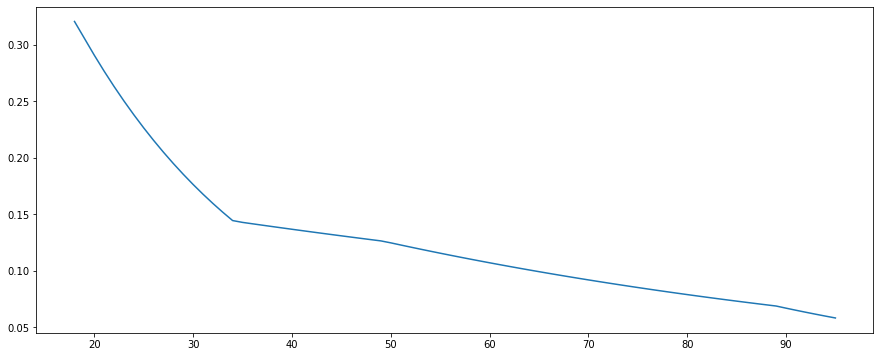

In [ ]:
# plotting
age = tf.cast(np.array(range(18,96)), tf.float32)
nn_pred = nn_freq_ageph.predict(age)
plt.plot(age, nn_pred)

(36, 50]    43404
(60, 96]    27643
(30, 36]    17747
(25, 30]    12826
(50, 55]    12543
(55, 60]    10105
(22, 25]     4901
(16, 22]     1756
Name: ageph_binned, dtype: int64


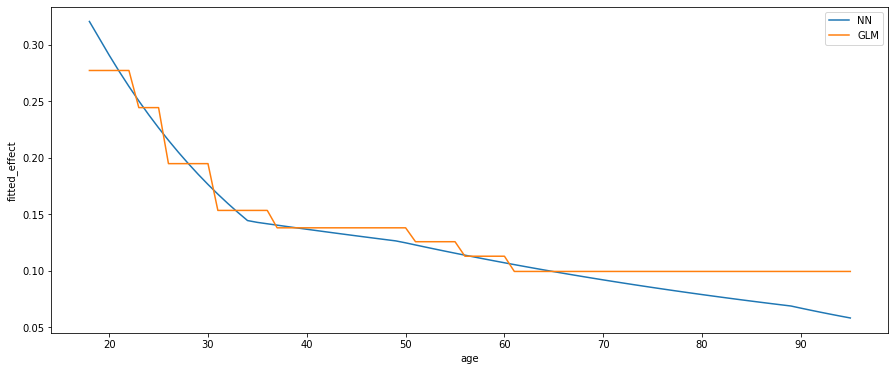

In [ ]:
# bin for train dataset
bins = [16,22,25,30,36,50,55,60,96]
train['ageph_binned'] = pd.cut(train['AGEPH'], bins = bins); print(train.ageph_binned.value_counts());
glm_age_binned = sm.formula.glm("nbrtotc ~ ageph_binned", 
                            data=train, 
                            offset = np.log(train.duree),
                            family=sm.families.Poisson()).fit(); 


age_binned = pd.cut(np.array(range(18,96)), bins = bins);
glm_pred = glm_age_binned.predict(pd.DataFrame({'ageph_binned':age_binned}))

plt.plot(age, nn_pred, label = 'NN')
plt.plot(age, glm_pred, label = "GLM")
plt.xlabel('age')
plt.ylabel('fitted_effect')
plt.legend()
plt.show()


As we see on the graph, the Neural Network fits a smooth age effect, but does not capture:
the elevated risk for young drivers and
the increased risk at old ages


*In the code below , we will fit a neural network with the same input as the last GLM we chose in the Method 1. We will then evaluate and compare performance with deviance, mse of the model. We will try to fit different network with different size for the analysis*


In [ ]:

preprocessing = ColumnTransformer([
   
  ("nom", OneHotEncoder(), ['AGEPH_cat']),
  ("nom2", OneHotEncoder(), ['split']),
  ("nom3", OneHotEncoder(), ['fuelc']),
  ("nom4", OneHotEncoder(), ['agecar']),
  ("nom5", OneHotEncoder(), ['coverp']),
  ("nom6", OneHotEncoder(), ['powerc'])
  
  
])

X_train_sub=my_data_X_train[['AGEPH_cat', 'split', 'fuelc', 'agecar','coverp', 'powerc']]
X_test_sub=my_data_X_test[['AGEPH_cat','split', 'fuelc', 'agecar', 'coverp', 'powerc']]

preprocessing.fit(X_train_sub,my_data_y_train)
X_train_sub_trans=preprocessing.transform(X_train_sub)
X_test_sub_trans=preprocessing.transform(X_test_sub)

print(X_train_sub.shape)
print(X_train_sub_trans.shape)
input_intercept = X_train_sub_trans
print(input_intercept)


# create a vector with exposure values
exposure = np.array(train['duree']) # pd.Series must be converted to pd.array due to compatibility reasons with fit() method
# neural network architecture specification
nn_freq_ageph = tf.keras.models.Sequential()
nn_freq_ageph.add(tf.keras.layers.Dense(units = 1, activation = 'exponential', input_shape = (31,), use_bias =True))
nn_freq_ageph.compile(optimizer = 'RMSprop', loss = 'poisson', metrics = [tf.keras.metrics.MeanSquaredError()])

nn_freq_ageph.fit(input_intercept,
                counts/exposure,
                 sample_weight = exposure,
                epochs = 40,
                 batch_size = 1024,
                validation_split = 0,
                 verbose = 1)


(130925, 6)
(130925, 31)
[[1 0 0 ... 1 0 0]
 [0 1 0 ... 1 0 0]
 [0 0 1 ... 1 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 1 0 0]]
Epoch 1/40
128/128 [==============================] - 1s 1ms/step - loss: 0.8080 - mean_squared_error: 1.6903
Epoch 2/40
128/128 [==============================] - 0s 1ms/step - loss: 0.4791 - mean_squared_error: 1.0246
Epoch 3/40
128/128 [==============================] - 0s 1ms/step - loss: 0.3895 - mean_squared_error: 0.9346
Epoch 4/40
128/128 [==============================] - 0s 2ms/step - loss: 0.3726 - mean_squared_error: 0.9261
Epoch 5/40
128/128 [==============================] - 0s 1ms/step - loss: 0.3668 - mean_squared_error: 0.9239
Epoch 6/40
128/128 [==============================] - 0s 1ms/step - loss: 0.3641 - mean_squared_error: 0.9227
Epoch 7/40
128/128 [==============================] - 0s 1ms/step - loss: 0.3629 - mean_squared_error: 0.9221
Epoch 8/40
128/128 [==============================] - 0s 1ms/step - loss: 0.3626 - me

In [ ]:
mu = nn_freq_ageph.predict(input_intercept)[:,0]*exposure
print(mu)
print(nn_freq_ageph.predict(input_intercept))
log_ratio = np.where(counts == 0, 0, np.log(counts / mu))
deviance_nn = 2 * sum(counts * log_ratio - (counts - mu))
deviance_nn


[0.14625238 0.11521807 0.09270171 ... 0.13854036 0.11416193 0.00335105]
[[0.14625238]
 [0.11521807]
 [0.09270171]
 ...
 [0.13854036]
 [0.11416193]
 [0.13590382]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


70514.675431349

In [ ]:

# neural network architecture specification
nn_freq_ageph = tf.keras.models.Sequential()
nn_freq_ageph.add(tf.keras.layers.Dense(units = 5, activation = 'relu', input_shape = (31,)))
nn_freq_ageph.add(tf.keras.layers.Dense(units = 1, activation = 'exponential', use_bias = True)) 
nn_freq_ageph.summary()

nn_freq_ageph.compile(optimizer = 'RMSprop', loss = 'poisson', metrics = [tf.keras.metrics.MeanSquaredError()])

nn_freq_ageph.fit(input_intercept,
                counts/exposure,
                 sample_weight = exposure,
                epochs = 40,
                 batch_size = 1024,
                validation_split = 0,
                 verbose = 1)


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 5)                 160       
                                                                 
 dense_15 (Dense)            (None, 1)                 6         
                                                                 
Total params: 166
Trainable params: 166
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
128/128 [==============================] - 1s 2ms/step - loss: 0.6511 - mean_squared_error: 1.2901
Epoch 2/40
128/128 [==============================] - 0s 3ms/step - loss: 0.3833 - mean_squared_error: 0.9304
Epoch 3/40
128/128 [==============================] - 0s 2ms/step - loss: 0.3662 - mean_squared_error: 0.9230
Epoch 4/40
128/128 [==============================] - 0s 2ms/step - loss: 0.3635 - mean_squared_error: 0.9222
Epoch 5/40


In [ ]:
mu = nn_freq_ageph.predict(input_intercept)[:,0]*exposure
log_ratio = np.where(counts == 0, 0, np.log(counts / mu))
deviance_nn = 2 * sum(counts * log_ratio - (counts - mu))

deviance_nn

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


70458.62738996182

In [ ]:
# evaluate performance of nn_freq_ageph on test data
ageph_test=X_test_sub_trans
counts_test = np.array(test['nbrtotc'])
exposure_test = np.array(test['duree'])
results=nn_freq_ageph.evaluate(ageph_test, counts_test/exposure_test, sample_weight=exposure_test, verbose = 0)

print("test Poisson loss, test MSE:", results)

test Poisson loss, test MSE: [0.36235108971595764, 1.0689622163772583]


In [ ]:
ageph_train=X_train_sub_trans
counts = np.array(train['nbrtotc'])
exposure= np.array(train['duree'])
results=nn_freq_ageph.evaluate(ageph_train, counts/exposure, sample_weight=exposure, verbose = 0)

print("train Poisson loss, test MSE:", results)

train Poisson loss, test MSE: [0.3619447946548462, 0.9210168123245239]


In [ ]:
def best_NN(j, activation, optimizer):
  i = 1
  while i <= j:
    print(i)
    tf.keras.backend.clear_session()
    nn_freq_ageph = tf.keras.models.Sequential()
    nn_freq_ageph.add(tf.keras.layers.Dense(units = i, activation = activation, input_shape = (31,)))
    nn_freq_ageph.add(tf.keras.layers.Dense(units = 1, activation = 'exponential', use_bias = True)) 
    nn_freq_ageph.compile(optimizer = optimizer, loss = 'poisson', metrics = [tf.keras.metrics.MeanSquaredError()])
    nn_freq_ageph.fit(input_intercept,
                counts/exposure,
                 sample_weight = exposure,
                epochs = 40,
                 batch_size = 1024,
                validation_split = 0,
                 verbose = 0)
    mu = nn_freq_ageph.predict(input_intercept)[:,0]*exposure
    log_ratio = np.where(counts == 0, 0, np.log(counts / mu))
    deviance_nn = 2 * sum(counts * log_ratio - (counts - mu))
    results_test=nn_freq_ageph.evaluate(ageph_test, counts_test/exposure_test, sample_weight=exposure_test, verbose = 0)
    print("model with"," ", "optimizer=", str(optimizer), " " , "and activation=", str(activation), str(i), " ", "neurons in the hiden layer","test Poisson loss, test MSE:", results_test , " deviance", str(deviance_nn))
    i += 1



np.random.seed(8)

best_NN(10, 'relu','RMSprop')
best_NN(10, 'relu','adam')
best_NN(10, 'softmax','RMSprop')
best_NN(10, 'softmax','adam')
best_NN(10, 'sigmoid','RMSprop')
best_NN(10, 'sigmoid','adam')



1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log


model with   optimizer= RMSprop   and activation= relu 1   neurons in the hiden layer test Poisson loss, test MSE: [0.36820894479751587, 1.0716134309768677]  deviance 72136.96395865525
2
model with   optimizer= RMSprop   and activation= relu 2   neurons in the hiden layer test Poisson loss, test MSE: [0.3621821999549866, 1.0688822269439697]  deviance 70514.07386642542
3
model with   optimizer= RMSprop   and activation= relu 3   neurons in the hiden layer test Poisson loss, test MSE: [0.3621944189071655, 1.068958044052124]  deviance 70510.91061239215
4
model with   optimizer= RMSprop   and activation= relu 4   neurons in the hiden layer test Poisson loss, test MSE: [0.3622715473175049, 1.0689938068389893]  deviance 70486.61203069979
5
model with   optimizer= RMSprop   and activation= relu 5   neurons in the hiden layer test Poisson loss, test MSE: [0.36231186985969543, 1.0689069032669067]  deviance 70433.24190467419
6
model with   optimizer= RMSprop   and activation= relu 6   neurons in